# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


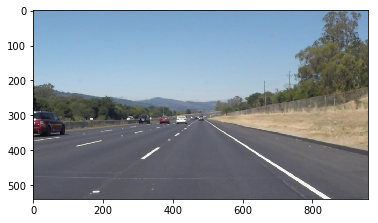

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [15]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def convert_hls(img):
    """Applies the HSL transform"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    right_line_x = []
    right_line_y = []
    left_line_x = []
    left_line_y = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)
            if (abs(slope) > 0.5) and (x1 != x2):
                if slope < 0: 
                    #left_line.append(line)
                    left_line_x.append((x1+x2)/2)
                    left_line_y.append((y1+y2)/2)
                else:
                    right_line_x.append((x1+x2)/2)
                    right_line_y.append((y1+y2)/2)
            
        cv2.line(img, (x1, y1), (x2, y2), color, thickness)
 
    color=[0, 0, 255]
    thickness = 3
    line_coef_left = np.polyfit(left_line_x, left_line_y, 1)
    line_eq_left = np.poly1d(line_coef_left)
    left_line_x.sort()    
    cv2.line(img, (int(left_line_x[-1]), int(line_eq_left(int(left_line_x[-1])))), (50, int(line_eq_left(50))), color, thickness)
    #cv2.line(img, (int(left_line_x[-1]), int(line_eq_left(int(left_line_x[-1])))), (int(left_line_x[0]), int(line_eq_left(int(left_line_x[0])))), color, thickness)
    
    line_coef_right = np.polyfit(right_line_x, right_line_y, 1)
    line_eq_right = np.poly1d(line_coef_right)
    right_line_x.sort()
    cv2.line(img, (int(right_line_x[0]), int(line_eq_right(int(right_line_x[0])))), (img.shape[1]-50, int(line_eq_right(img.shape[1]-50))), color, thickness)
    #cv2.line(img, (int(right_line_x[0]), int(line_eq_right(int(right_line_x[0])))), (int(right_line_x[-1]), int(line_eq_right(int(right_line_x[-1])))), color, thickness)


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def white_color_enhance(img):
    lower = np.uint8([  0, 200,   0])
    upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(img, lower, upper)
    return cv2.bitwise_and(img, img, mask = white_mask) , white_mask

def yellow_color_enhance(img):
    lower = np.uint8([  10, 0, 100])
    upper = np.uint8([40, 255, 255])
    yellow_mask = cv2.inRange(img, lower, upper)
    return cv2.bitwise_and(img, img, mask = yellow_mask) , yellow_mask

def white_yellow_enhance(img, white_mask, yellow_mask):
    overall_mask = cv2.bitwise_or(white_mask, yellow_mask)
    return cv2.bitwise_and(img, img, mask = overall_mask)
        
    
    

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
image_list = os.listdir("test_images/")

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

test_images_output/solidWhiteCurve.jpg
test_images_output/solidWhiteRight.jpg
test_images_output/solidYellowCurve.jpg
test_images_output/solidYellowCurve2.jpg
test_images_output/solidYellowLeft.jpg
test_images_output/whiteCarLaneSwitch.jpg


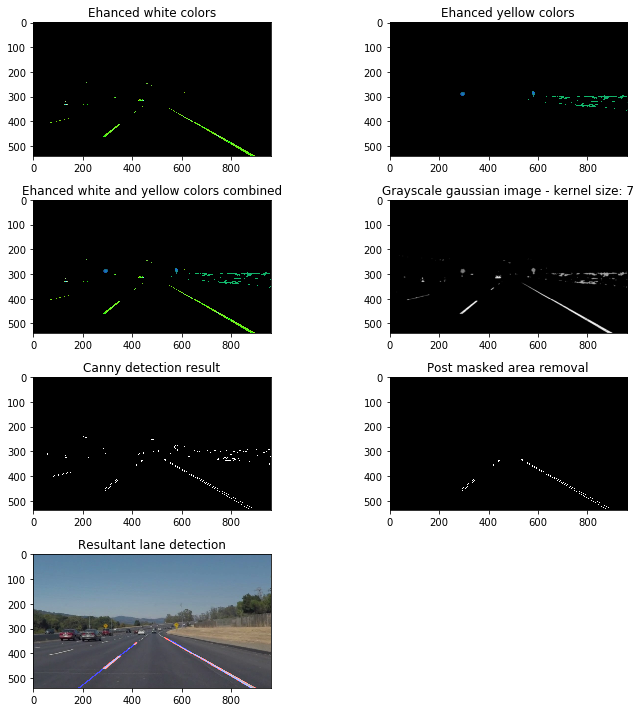

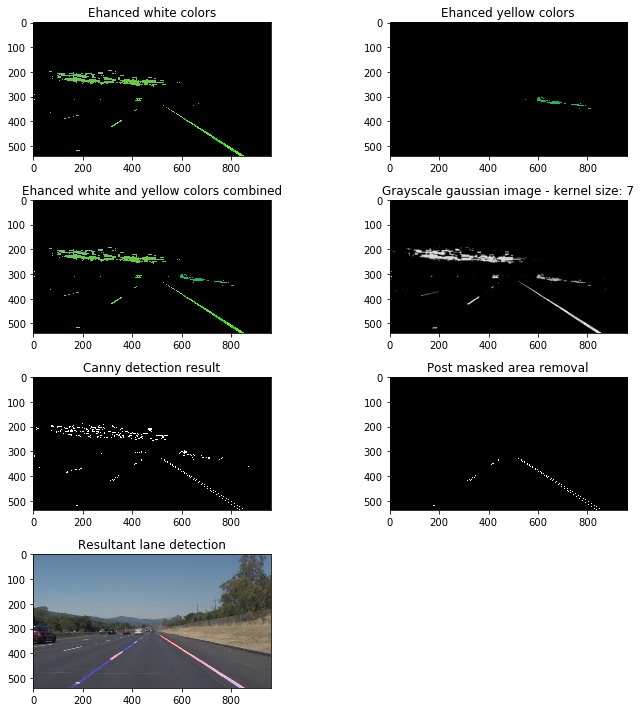

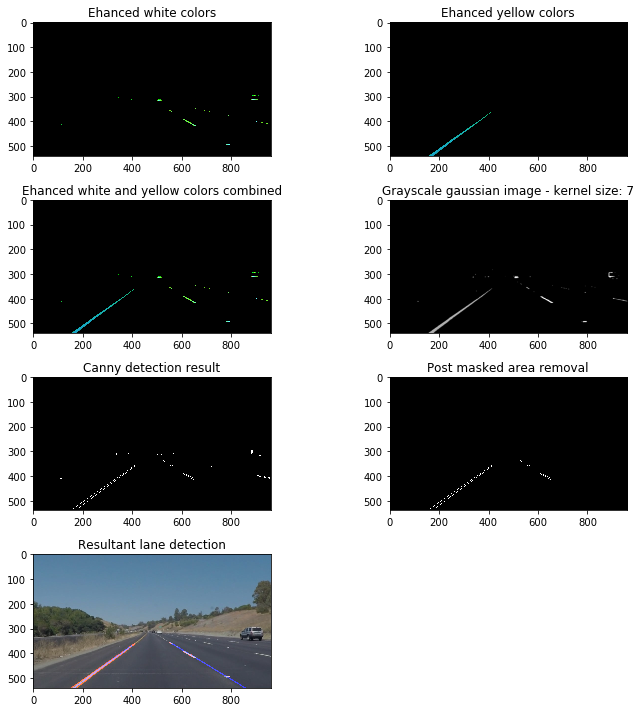

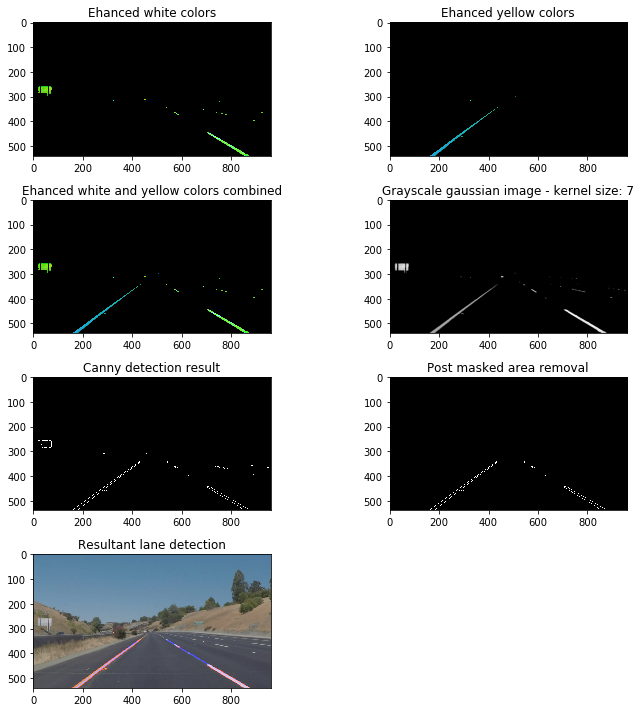

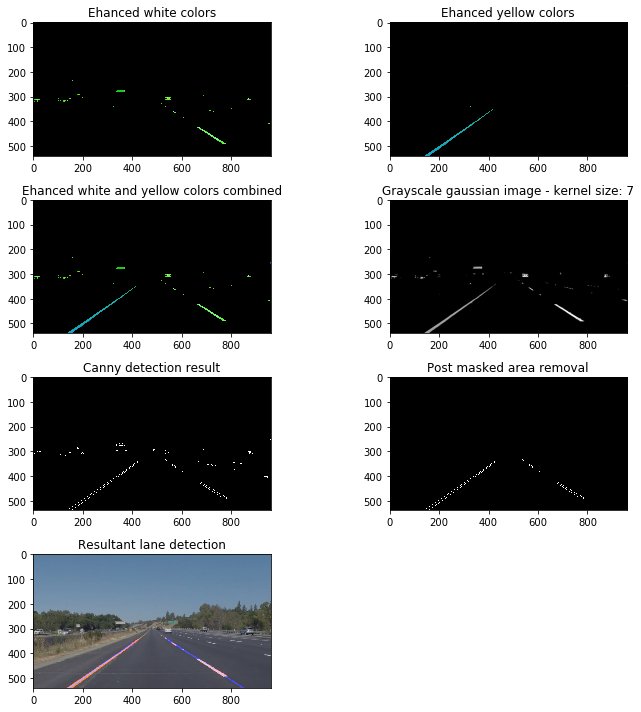

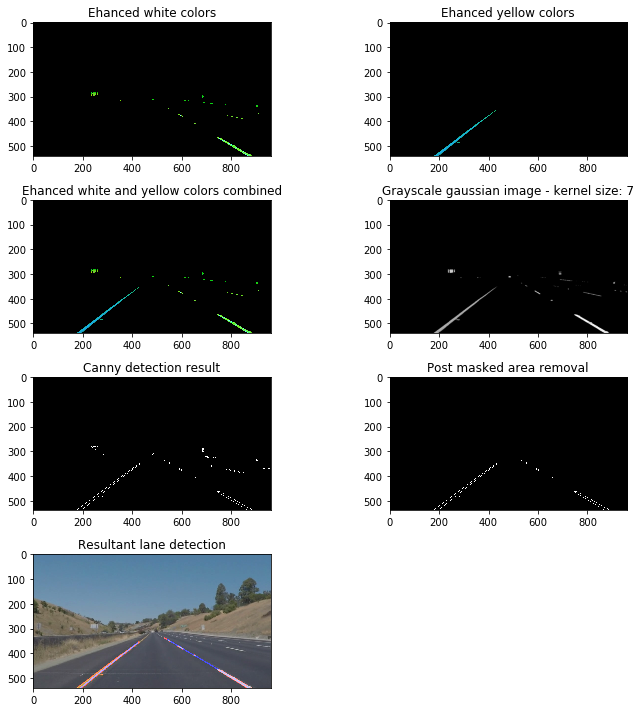

In [5]:
input_folder = 'test_images/'
output_folder = 'test_images_output/'

for image_name in image_list:
    #reading in an image
    image = mpimg.imread(str(input_folder + image_name))

    # TODO: Build your pipeline that will draw lane lines on the test_images
    # then save them to the test_images directory.
    
    # Use figure so multiple images can be displayed at one time
    fig  = plt.figure(figsize=(10, 10))
    rows = 4
    cols = 2
    idx = 0
    
    #Convert to HSL and enhance white and yellow lines
    hls_image = convert_hls(image)
        
    # white color ehancement
    white_image , white_mask = white_color_enhance(hls_image)    
    idx+=1
    ax = plt.subplot(rows, cols, idx)
    plt.imshow(white_image)
    plt.title('Ehanced white colors')
    
    # yellow color mask
    yellow_image , yellow_mask = yellow_color_enhance(hls_image)
    idx+=1
    ax = plt.subplot(rows, cols, idx)
    plt.imshow(yellow_image)
    plt.title('Ehanced yellow colors')
    
    #Combine yellow and white masks
    yellow_white_image = white_yellow_enhance(hls_image, white_mask, yellow_mask)
    idx+=1
    ax = plt.subplot(rows, cols, idx)
    plt.imshow(yellow_white_image)
    plt.title('Ehanced white and yellow colors combined')
    
    #Convert to grayscale and apply a gaussian blur 
    gray = grayscale(yellow_white_image)
    kernel_size = 7
    blur_gray  = gaussian_blur(gray, kernel_size)
    idx+=1
    ax = plt.subplot(rows, cols, idx)
    plt.imshow(blur_gray, cmap='gray')
    plt.title('Grayscale gaussian image - kernel size: '+str(kernel_size))

    # Canny edge detection
    low_threshold = 50
    high_threshold = 150
    canny_image = canny(blur_gray, low_threshold, high_threshold)
    idx+=1
    ax = plt.subplot(rows, cols, idx)
    plt.imshow(canny_image, cmap='gray')
    plt.title('Canny detection result')

    # Creating mask area
    imshape = canny_image.shape
    vertices = np.array([[(50,imshape[0]),(425, 325), (imshape[1]-425, 325), (imshape[1]-50,imshape[0])]], dtype=np.int32)
    masked_canny_image = region_of_interest(canny_image, vertices)
    idx+=1
    ax = plt.subplot(rows, cols, idx)
    plt.imshow(masked_canny_image, cmap='gray')
    plt.title('Post masked area removal')

    #Hough transform stage to find line segments
    #Parameters for hough
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = (np.pi/180)  # angular resolution in radians of the Hough grid
    threshold = 15     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 5 #minimum number of pixels making up a line
    max_line_gap = 15    # maximum gap in pixels between connectable line segments
    hough_image = hough_lines(masked_canny_image, rho, theta, threshold, min_line_length, max_line_gap)
    result_image = weighted_img(hough_image, image)
    idx+=1
    ax = plt.subplot(rows, cols, idx)
    plt.title('Resultant lane detection')
    plt.imshow(result_image)
    plt.tight_layout()

    # Save resulting image
    output_path = os.path.join(output_folder,image_name)
    print(output_path)
    if (os.path.isfile(output_path)):
            os.remove(output_path)
    plt.savefig(output_path, bbox_inches='tight')

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [7]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    #Gaussian blur 
    #Convert to HSL and enhance white and yellow lines
    test_image = np.copy(image)
    hls_image = convert_hls(test_image)
        
    # white color ehancement
    white_image , white_mask = white_color_enhance(hls_image)    
   
    # yellow color mask
    yellow_image , yellow_mask = yellow_color_enhance(hls_image)
    
    #Combine yellow and white masks
    yellow_white_image = white_yellow_enhance(hls_image, white_mask, yellow_mask)
    
    #Convert to grayscale and apply a gaussian blur 
    gray = grayscale(yellow_white_image)
    kernel_size = 7 #7
    blur_gray  = gaussian_blur(gray, kernel_size)

    # Canny edge detection
    low_threshold = 100 #default = 100
    high_threshold = 200 #default = 200
    canny_image = canny(blur_gray, low_threshold, high_threshold)

    # Creating mask area
    imshape = canny_image.shape
    vertices = np.array([[(50,imshape[0]),(425, 325), (imshape[1]-425, 325), (imshape[1]-50,imshape[0])]], dtype=np.int32)
    masked_canny_image = region_of_interest(canny_image, vertices)

    #Hough transform stage to find line segments
    #Parameters for hough
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = (np.pi/180)  # angular resolution in radians of the Hough grid
    threshold = 15     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 5 #minimum number of pixels making up a line
    max_line_gap = 15    # maximum gap in pixels between connectable line segments
    hough_image = hough_lines(masked_canny_image, rho, theta, threshold, min_line_length, max_line_gap)
    result_image = weighted_img(hough_image, image)

    return result_image

Let's try the one with the solid white lane on the right first ...

In [8]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 221/222 [00:07<00:00, 31.29it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 7.97 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [16]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

0.647619047619
0.704081632653
0.666666666667
0.666666666667
0.666666666667
0.714285714286
0.636363636364
0.666666666667
0.666666666667
0.62962962963
0.727272727273
0.6
0.711538461538
0.666666666667
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


  0%|                                                                                                                                                                  | 0/682 [00:00<?, ?it/s]

0.647619047619
0.704081632653
0.666666666667
0.666666666667
0.666666666667
0.714285714286
0.636363636364
0.666666666667
0.666666666667
0.62962962963
0.727272727273
0.6
0.711538461538
0.666666666667
0.7
0.65034965035
0.692307692308
0.648275862069
0.69696969697
0.714285714286
0.777777777778
0.647058823529
0.711538461538
0.6875
0.6
0.692307692308
0.666666666667
0.733333333333


  0%|▍                                                                                                                                                         | 2/682 [00:00<00:50, 13.51it/s]

0.65
0.711538461538
0.647058823529
0.735294117647
0.636363636364
0.769230769231
0.6875
0.631578947368
0.666666666667
0.636363636364
0.658536585366
0.647058823529
0.6
0.75
0.666666666667
0.727272727273
0.764705882353
0.631578947368
0.650793650794
0.703703703704
0.625
0.684210526316
0.6
0.666666666667
0.7
0.698630136986
0.625
0.666666666667
0.6875
0.666666666667


  1%|▉                                                                                                                                                         | 4/682 [00:00<00:50, 13.32it/s]

0.627906976744
0.694444444444
0.6
0.636363636364
0.777777777778
0.710526315789
0.666666666667
0.714285714286
0.6
0.571428571429
0.65
0.636363636364
0.636363636364
0.653846153846
0.642857142857
0.666666666667
0.666666666667
0.571428571429


  1%|█▎                                                                                                                                                        | 6/682 [00:00<00:46, 14.55it/s]

0.7
0.620689655172
0.666666666667
0.6875
0.655172413793
0.714285714286
0.692307692308
0.714285714286
0.6
0.655172413793
0.625
0.666666666667
0.589743589744
0.666666666667
0.75
0.583333333333
0.657142857143
0.875
0.666666666667
0.633333333333
0.666666666667


  1%|█▊                                                                                                                                                        | 8/682 [00:00<00:45, 14.92it/s]

0.7
0.666666666667
0.666666666667
0.6
0.622222222222
0.636363636364
0.666666666667
0.625
0.685714285714
0.782608695652
0.68
0.666666666667
0.622641509434
0.6
0.63829787234
0.7
0.673913043478
0.6
0.636363636364


  1%|██▏                                                                                                                                                      | 10/682 [00:00<00:43, 15.55it/s]

0.612903225806
0.722222222222
0.545454545455
0.583333333333
0.677419354839
0.629032258065
0.636363636364
0.672413793103
0.680555555556
0.615384615385
0.615384615385
0.684210526316
0.689655172414
0.583333333333
0.6
0.565217391304
0.666666666667
0.6
0.571428571429
0.642857142857


  2%|██▋                                                                                                                                                      | 12/682 [00:00<00:40, 16.50it/s]

0.616161616162
0.677419354839
0.642857142857
0.615384615385
0.583333333333
0.681818181818
0.642857142857
0.666666666667
0.625
0.666666666667
0.59375
0.625
0.625954198473
0.625
0.648936170213
0.642857142857
0.646153846154
0.6
0.595238095238
0.642857142857
0.609756097561
0.615384615385
0.634615384615
0.642857142857
0.624113475177
0.654135338346
0.666666666667
0.7
0.6
0.722222222222
0.633333333333
0.638888888889
0.604651162791
0.625
0.714285714286
0.75
0.652173913043
0.615384615385
0.727272727273
0.658536585366
0.571428571429


  2%|███▎                                                                                                                                                     | 15/682 [00:00<00:38, 17.14it/s]

0.647619047619
0.604166666667
0.666666666667
0.714285714286
0.595744680851
0.611111111111
0.660377358491
0.6
0.607142857143
0.65
0.666666666667
0.631578947368
0.739130434783
0.625
0.666666666667
0.545454545455
0.594594594595
0.650793650794
0.652173913043
0.56
0.695652173913
0.610169491525
0.661290322581
0.692307692308
0.68
0.666666666667
0.615384615385
0.619047619048


  2%|███▊                                                                                                                                                     | 17/682 [00:01<00:38, 17.35it/s]

0.608695652174
0.653846153846
0.571428571429
0.642857142857
0.6
0.6
0.666666666667
0.64
0.571428571429
0.571428571429
0.6
0.571428571429
0.625
0.607142857143
0.617647058824
0.678571428571
0.612903225806
0.625
0.625
0.625
0.625
0.6
0.666666666667


  3%|████▎                                                                                                                                                    | 19/682 [00:01<00:37, 17.87it/s]

0.594594594595
0.625
0.615384615385
0.571428571429
0.633333333333
0.666666666667
0.625
0.578947368421
0.714285714286
0.609756097561
0.685714285714
0.6
0.666666666667
0.6
0.621621621622
0.636363636364
0.6
0.6
0.65
0.652173913043
0.612244897959
0.666666666667
0.625
0.571428571429
0.630434782609
0.571428571429
0.636363636364
0.833333333333
0.714285714286


  3%|████▉                                                                                                                                                    | 22/682 [00:01<00:35, 18.77it/s]

0.629032258065
0.641509433962
0.648148148148
0.627118644068
0.6
0.8
0.6
0.666666666667
0.545454545455
0.652173913043
0.583333333333
0.6
0.615384615385
0.628571428571
0.615384615385
0.586206896552
0.533333333333
0.565217391304
0.642857142857
0.6
0.666666666667
0.666666666667
0.65625
0.6
0.6875
0.666666666667


  4%|█████▍                                                                                                                                                   | 24/682 [00:01<00:34, 18.91it/s]

0.64367816092
0.617021276596
0.705882352941
0.6
0.5625
0.733333333333
0.6
0.625
0.634146341463
0.571428571429
0.666666666667
0.6
0.666666666667
0.615384615385
0.595041322314
0.646017699115
0.666666666667
0.571428571429
0.666666666667
0.615384615385
0.666666666667
0.6
0.6
0.6
0.6
0.623529411765
0.689655172414
0.692307692308
0.6
0.6
0.6
0.642857142857
0.694444444444


  4%|█████▊                                                                                                                                                   | 26/682 [00:01<00:36, 18.03it/s]

0.604651162791
0.650485436893
0.672413793103
0.585714285714
0.579710144928
0.611111111111
0.612244897959
0.625
0.636363636364
0.684210526316
0.681818181818
0.611111111111
0.642857142857
0.652173913043
0.65
0.571428571429
0.622950819672
0.603053435115
0.598484848485
0.666666666667
0.620967741935
0.695652173913
0.555555555556
0.526315789474
0.666666666667
0.6
0.6


  4%|██████▎                                                                                                                                                  | 28/682 [00:01<00:36, 18.02it/s]

0.584415584416
0.647727272727
0.666666666667
0.652173913043
0.678571428571
0.576923076923
0.705882352941
0.636363636364
0.551282051282
0.791666666667
0.6
0.666666666667
0.578947368421
0.615384615385
0.947368421053
0.595744680851
0.6
0.666666666667
0.586206896552
0.619047619048
0.6
0.625
0.615384615385
0.542857142857
0.625
0.666666666667
0.64
0.653846153846
0.642857142857
0.625
0.636363636364
0.6
0.555555555556


  4%|██████▋                                                                                                                                                  | 30/682 [00:01<00:41, 15.73it/s]

0.625
0.6875
0.642857142857
0.666666666667
0.619047619048
0.655172413793
0.6
0.6
0.625
0.620689655172
0.571428571429
0.6
0.678571428571
0.714285714286
0.666666666667
0.666666666667
0.666666666667
0.633333333333
0.6
0.666666666667
0.612903225806


  5%|███████▏                                                                                                                                                 | 32/682 [00:01<00:40, 16.15it/s]

0.666666666667
0.6
0.7
0.6
0.619047619048
0.592592592593
0.774193548387
0.613636363636
0.7
0.666666666667
0.666666666667
0.6
0.590909090909
0.545454545455
0.545454545455
0.622222222222
0.6
0.666666666667


  5%|███████▋                                                                                                                                                 | 34/682 [00:02<00:38, 16.67it/s]

0.589285714286
0.634615384615
0.666666666667
0.615384615385
0.592592592593
0.583333333333
0.625
0.727272727273
0.646153846154
0.617647058824
0.608695652174
0.75
0.666666666667
0.65
0.647058823529
0.6
0.625
0.727272727273
0.6
0.642857142857


  5%|████████                                                                                                                                                 | 36/682 [00:02<00:38, 16.88it/s]

0.595238095238
0.647058823529
0.642857142857
0.625
0.6
0.666666666667
0.5625
0.6
0.7
0.714285714286
0.6
0.636363636364
0.6
0.68
0.588235294118
0.596330275229
0.652173913043
0.666666666667
0.645161290323
0.596153846154
0.666666666667
0.5625
0.677419354839
0.615384615385
0.6


  6%|████████▌                                                                                                                                                | 38/682 [00:02<00:38, 16.65it/s]

0.573426573427
0.619565217391
0.625954198473
0.625
0.625
0.576470588235
0.636363636364
0.560975609756
0.621621621622
0.8
0.705882352941
0.6
0.8
0.577639751553
0.625850340136
0.6
0.625850340136
0.6
0.56
0.6
0.6
0.579545454545
0.631578947368
0.722222222222


  6%|████████▉                                                                                                                                                | 40/682 [00:02<00:38, 16.78it/s]

0.576
0.636363636364
0.605263157895
0.6
0.565217391304
0.581818181818
0.625
0.6125
0.681818181818
0.606060606061
0.666666666667
0.597402597403
0.619718309859
0.571428571429
0.583333333333
0.625
0.666666666667
0.652173913043
0.59375
0.62962962963
0.571428571429
0.666666666667
0.571428571429
0.628571428571
0.6
0.6
0.588235294118


  6%|█████████▍                                                                                                                                               | 42/682 [00:02<00:37, 17.13it/s]

0.588235294118
0.571428571429
0.64
0.692307692308
0.62962962963
0.53125
0.625
0.666666666667
0.666666666667
0.615384615385
0.6
0.642857142857
0.625
0.666666666667
0.62962962963
0.6
0.6
0.571428571429
0.571428571429
0.6


  6%|█████████▊                                                                                                                                               | 44/682 [00:02<00:36, 17.57it/s]

0.631578947368
0.628571428571
0.641025641026
0.6
0.6
0.625
0.571428571429
0.6
0.6
0.538461538462
0.636363636364
0.604651162791
0.586956521739
0.578947368421
0.571428571429
0.6
0.6
0.6
0.545454545455
0.545454545455
0.545454545455
0.666666666667
0.6


  7%|██████████▎                                                                                                                                              | 46/682 [00:02<00:36, 17.24it/s]

0.666666666667
0.615384615385
0.6
0.612244897959
0.611111111111
0.6
0.571428571429
0.615384615385
0.574074074074
0.62
0.636363636364
0.603174603175
0.666666666667
0.666666666667
0.642857142857
0.6
0.6
0.583333333333
0.727272727273
0.727272727273
0.627118644068
0.615384615385
0.609375
0.636363636364


  7%|██████████▊                                                                                                                                              | 48/682 [00:02<00:38, 16.44it/s]

0.597402597403
0.647887323944
0.6
0.533333333333
0.666666666667
0.64406779661
0.615384615385
0.6
0.590909090909
0.595744680851
0.642857142857
0.59793814433
0.642857142857
0.6
0.571428571429
0.657142857143
0.529411764706
0.625
0.6875
0.538461538462
0.6
0.666666666667


  7%|███████████▏                                                                                                                                             | 50/682 [00:02<00:38, 16.54it/s]

0.623931623932
0.588235294118
0.6
0.6
0.625
0.636363636364
0.588235294118
0.666666666667
0.6
0.577380952381
0.62091503268
0.577586206897
0.555555555556
0.6
0.625
0.5625
0.641025641026
0.619047619048
0.714285714286
0.63768115942
0.666666666667
0.6


  8%|███████████▋                                                                                                                                             | 52/682 [00:03<00:40, 15.65it/s]

0.578947368421
0.58041958042
0.62015503876
0.621052631579
0.584615384615
0.619047619048
0.6
0.764705882353
0.8
0.6
0.615384615385
0.714285714286
0.6
0.604395604396
0.575757575758
0.527777777778
0.666666666667
0.527777777778
0.625
0.591836734694
0.6
0.590163934426
0.695652173913
0.64
0.615384615385
0.6


  8%|████████████                                                                                                                                             | 54/682 [00:03<00:41, 15.32it/s]

0.625
0.56862745098
0.583333333333
0.625
0.571428571429
0.6
0.666666666667
0.6
0.595744680851
0.714285714286
0.666666666667
0.652173913043
0.625
0.533333333333
0.642857142857
0.666666666667
0.625
0.620689655172
0.6
0.578947368421
0.6
0.565217391304


  8%|████████████▌                                                                                                                                            | 56/682 [00:03<00:41, 15.06it/s]

0.555555555556
0.636363636364
0.625
0.606060606061
0.588235294118
0.59375
0.666666666667
0.7
0.571428571429
0.6
0.55
0.605263157895
0.6
0.571428571429
0.666666666667
0.625
0.555555555556
0.6


  9%|█████████████                                                                                                                                            | 58/682 [00:03<00:43, 14.50it/s]

0.651162790698
0.622222222222
0.583333333333
0.590909090909
0.6
0.636363636364
0.666666666667
0.545454545455
0.666666666667
0.574074074074
0.636363636364
0.65306122449
0.625
0.666666666667
0.571428571429
0.58064516129
0.7
0.571428571429
0.666666666667
0.6
0.571428571429


  9%|█████████████▍                                                                                                                                           | 60/682 [00:03<00:44, 13.86it/s]

0.571428571429
0.578125
0.619047619048
0.594202898551
0.6
0.636363636364
0.615384615385
0.64
0.6
0.618421052632
0.594936708861
0.615384615385
0.6
0.642857142857
0.584905660377
0.615384615385
0.612903225806
0.615384615385
0.6
0.666666666667


  9%|█████████████▉                                                                                                                                           | 62/682 [00:03<00:47, 12.93it/s]

0.6
0.636363636364
0.594059405941
0.618556701031
0.571428571429
0.642857142857
0.576923076923
0.6
0.666666666667
0.611111111111
0.624
0.588235294118
0.552631578947
0.566037735849
0.6
0.634146341463
0.636363636364
0.555555555556
0.5625
0.6
0.6
0.65


  9%|██████████████▎                                                                                                                                          | 64/682 [00:04<00:50, 12.21it/s]

0.623287671233
0.598639455782
0.6
0.578947368421
0.614035087719
0.642857142857
0.571428571429
0.6
0.65
0.588235294118
0.59756097561
0.585365853659
0.538461538462
0.612903225806
0.6
0.6
0.6
0.625
0.598360655738
0.6
0.648936170213
0.676470588235
0.604651162791
0.65
0.625
0.65625
0.636363636364
0.6
0.6
0.666666666667
0.6
0.588235294118
0.619047619048
0.657894736842
0.571428571429
0.571428571429


 10%|██████████████▊                                                                                                                                          | 66/682 [00:04<00:50, 12.25it/s]

0.583333333333
0.571428571429
0.626666666667
0.576923076923
0.608695652174
0.64
0.64
0.6
0.666666666667
0.571428571429
0.64
0.666666666667
0.64
0.652173913043
0.583333333333
0.666666666667
0.653846153846
0.62962962963
0.592592592593
0.666666666667
0.56
0.666666666667
0.6
0.6
0.571428571429
0.6


 10%|███████████████▎                                                                                                                                         | 68/682 [00:04<00:48, 12.65it/s]

0.5625
0.6
0.678571428571
0.620689655172
0.72
0.615384615385
0.657142857143
0.647058823529
0.6875
0.666666666667
0.633333333333
0.653846153846
0.8
0.75
0.633333333333


 10%|███████████████▋                                                                                                                                         | 70/682 [00:04<00:44, 13.86it/s]

0.666666666667
0.657894736842
0.581395348837
0.666666666667
0.628571428571
0.791666666667
0.595238095238
0.714285714286
0.591836734694
0.636363636364
0.692307692308
0.625
0.7
0.8
0.560975609756
0.666666666667
0.666666666667
0.571428571429


 11%|████████████████▏                                                                                                                                        | 72/682 [00:04<00:41, 14.73it/s]

0.641509433962
0.593220338983
0.64
0.6
0.545454545455
0.583333333333
0.636363636364
0.58904109589
0.646153846154
0.594202898551
0.571428571429
0.75
0.714285714286
0.8
0.648648648649
0.615384615385
0.714285714286


 11%|████████████████▌                                                                                                                                        | 74/682 [00:04<00:39, 15.30it/s]

0.666666666667
0.626506024096
0.6
0.573033707865
0.623529411765
0.56
0.571428571429
0.642857142857
0.65625
0.622641509434
0.598214285714
0.642857142857
0.602564102564
0.625
0.6
0.666666666667
0.666666666667
0.6
0.666666666667
0.6
0.59375
0.642857142857
0.69387755102


 11%|█████████████████                                                                                                                                        | 76/682 [00:04<00:38, 15.61it/s]

0.598639455782
0.625
0.621428571429
0.631578947368
0.612903225806
0.588235294118
0.571428571429
0.6
0.608695652174
0.583333333333
0.6
0.6
0.6
0.633333333333
0.602150537634
0.628205128205
0.598591549296
0.611111111111
0.638888888889
0.578947368421
0.585365853659
0.6
0.6
0.705882352941
0.620689655172
0.607142857143
0.605263157895
0.625
0.555555555556
0.6
0.583333333333
0.6


 11%|█████████████████▍                                                                                                                                       | 78/682 [00:04<00:41, 14.62it/s]

0.6
0.645833333333
0.641509433962
0.601851851852
0.608695652174
0.666666666667
0.666666666667
0.6
0.65
0.6
0.714285714286
0.6
0.64
0.576923076923
0.59649122807
0.666666666667
0.590909090909
0.6
0.625
0.541666666667
0.571428571429
0.6
0.62962962963
0.6


 12%|█████████████████▉                                                                                                                                       | 80/682 [00:05<00:41, 14.61it/s]

0.6
0.64
0.607142857143
0.642857142857
0.647058823529
0.666666666667
0.555555555556
0.6
0.625
0.65625
0.655172413793
0.607142857143
0.6
0.571428571429
0.666666666667
0.571428571429
0.571428571429


 12%|██████████████████▍                                                                                                                                      | 82/682 [00:05<00:42, 14.05it/s]

0.677419354839
0.641025641026
0.666666666667
0.625
0.6
0.666666666667
0.769230769231
0.638888888889
0.655172413793
0.692307692308
0.613636363636
0.622222222222
0.625
0.6
0.555555555556
0.6
0.6
0.666666666667
0.62962962963


 12%|██████████████████▊                                                                                                                                      | 84/682 [00:05<00:42, 14.00it/s]

0.607843137255
0.604166666667
0.595238095238
0.6
0.653846153846
0.588235294118
0.6
0.607142857143
0.8
0.625
0.615384615385
0.672413793103
0.727272727273
0.636363636364
0.615384615385
0.65
0.636363636364
0.6


 13%|███████████████████▎                                                                                                                                     | 86/682 [00:05<00:48, 12.41it/s]

0.620253164557
0.643835616438
0.613636363636
0.6
0.571428571429
0.583333333333
0.7
0.698113207547
0.636363636364
0.636363636364
0.692307692308
0.626666666667
0.571428571429
0.666666666667
0.616161616162
0.6
0.615384615385
0.611111111111
0.615384615385
0.6
0.607142857143
0.636363636364
0.690476190476


 13%|███████████████████▋                                                                                                                                     | 88/682 [00:05<00:48, 12.16it/s]

0.672413793103
0.631578947368
0.59842519685
0.5625
0.666666666667
0.586206896552
0.625
0.604166666667
0.65
0.642857142857
0.631578947368
0.571428571429
0.6
0.650684931507
0.601769911504
0.666666666667
0.666666666667
0.6875
0.727272727273
0.625
0.611111111111
0.6875
0.6875
0.660714285714
0.666666666667
0.714285714286
0.591836734694
0.65
0.645161290323


 13%|████████████████████▏                                                                                                                                    | 90/682 [00:05<00:47, 12.49it/s]

0.642857142857
0.6
0.631578947368
0.583333333333
0.611111111111
0.6
0.648
0.603773584906
0.6
0.555555555556
0.625
0.575757575758
0.666666666667
0.6
0.6
0.625
0.571428571429
0.611111111111
0.611111111111
0.606060606061
0.629032258065
0.55223880597
0.647727272727
0.6
0.6
0.619047619048
0.551724137931
0.695652173913
0.666666666667
0.526315789474
0.565217391304
0.673076923077
0.714285714286
0.583333333333
0.684210526316
0.666666666667
0.565217391304


 13%|████████████████████▋                                                                                                                                    | 92/682 [00:06<00:47, 12.38it/s]

0.619047619048
0.652173913043
0.541666666667
0.607142857143
0.545454545455
0.64
0.666666666667
0.642857142857
0.6
0.681818181818
0.647058823529
0.642857142857
0.588235294118
0.6
0.666666666667
0.681818181818
0.636363636364
0.6
0.666666666667
0.652173913043
0.666666666667
0.6
0.666666666667
0.653846153846


 14%|█████████████████████                                                                                                                                    | 94/682 [00:06<00:44, 13.17it/s]

0.6
0.62962962963
0.625
0.653846153846
0.571428571429
0.65
0.676470588235
0.6
0.689655172414
0.703703703704
0.758620689655
0.666666666667
0.611111111111
0.571428571429
0.6
0.6
0.638888888889
0.615384615385
0.634146341463
0.75
0.636363636364
0.65625
0.583333333333
0.6
0.666666666667
0.636363636364


 14%|█████████████████████▊                                                                                                                                   | 97/682 [00:06<00:40, 14.32it/s]

0.644444444444
0.617021276596
0.571428571429
0.571428571429
0.6
0.645833333333
0.64
0.666666666667
0.636363636364
0.636363636364
0.6
0.636363636364
0.62962962963
0.714285714286
0.69696969697
0.6
0.777777777778
0.637931034483
0.6
0.75


 15%|██████████████████████▏                                                                                                                                  | 99/682 [00:06<00:39, 14.88it/s]

0.65671641791
0.692307692308
0.666666666667
0.676470588235
0.666666666667
0.6
0.625
0.666666666667
0.742857142857
0.75
0.777777777778
0.666666666667
0.666666666667
0.666666666667
0.727272727273
0.526315789474
0.615384615385
0.646341463415
0.597701149425
0.571428571429
0.571428571429
0.6
0.6
0.666666666667
0.678571428571
0.583333333333
0.6
0.666666666667
0.666666666667
0.666666666667


 15%|██████████████████████▌                                                                                                                                 | 101/682 [00:06<00:40, 14.32it/s]

0.604938271605
0.650485436893
0.647619047619
0.6
0.625
0.589743589744
0.611111111111
0.6
0.642857142857
0.6
0.583333333333
0.666666666667
0.617021276596
0.6875
0.6
0.644927536232
0.6
0.6
0.588235294118
0.637931034483
0.62962962963
0.6
0.578947368421
0.666666666667


 15%|██████████████████████▉                                                                                                                                 | 103/682 [00:06<00:44, 12.92it/s]

0.623076923077
0.653225806452
0.625
0.6875
0.630434782609
0.611111111111
0.630434782609
0.684210526316
0.659574468085
0.833333333333
0.55
0.68
0.626262626263
0.66
0.625
0.697674418605
0.65
0.625
0.684210526316
0.6
0.657142857143
0.6
0.636363636364
0.733333333333
0.727272727273


 15%|███████████████████████▍                                                                                                                                | 105/682 [00:07<00:50, 11.47it/s]

0.6
0.681818181818
0.596153846154
0.619047619048
0.717391304348
0.666666666667
0.589285714286
0.75
0.571428571429
0.714285714286
0.6
0.65
0.529411764706
0.592592592593
0.62962962963
0.642857142857
0.571428571429
0.615384615385
0.571428571429
0.586206896552


 16%|███████████████████████▊                                                                                                                                | 107/682 [00:07<00:54, 10.60it/s]

0.666666666667
0.555555555556
0.633333333333
0.633333333333
0.666666666667
0.666666666667
0.620689655172
0.612903225806
0.6
0.642857142857
0.6
0.666666666667
0.6
0.65625
0.675675675676
0.642857142857
0.571428571429
0.666666666667
0.678571428571
0.677419354839
0.571428571429


 16%|████████████████████████▎                                                                                                                               | 109/682 [00:07<00:55, 10.32it/s]

0.604651162791
0.666666666667
0.7
0.75
0.642857142857
0.666666666667
0.615384615385
0.666666666667
0.769230769231
0.666666666667
0.6
0.636363636364
0.7
0.8
0.592592592593
0.627450980392
0.607843137255
0.636363636364
0.7
0.666666666667
0.588235294118
0.6


 16%|████████████████████████▋                                                                                                                               | 111/682 [00:07<00:52, 10.91it/s]

0.609756097561
0.575
0.59375
0.666666666667
0.615384615385
0.515151515152
0.622222222222
0.6
0.602564102564
0.647887323944
0.604166666667
0.571428571429
0.714285714286
0.571428571429
0.727272727273
0.666666666667
0.714285714286


 17%|█████████████████████████▏                                                                                                                              | 113/682 [00:07<00:46, 12.21it/s]

0.67816091954
0.625
0.6
0.666666666667
0.571428571429
0.6
0.6
0.6875
0.621052631579
0.642857142857
0.642857142857
0.625
0.636363636364
0.646551724138
0.6
0.625
0.6
0.596774193548
0.666666666667
0.6
0.625
0.660714285714
0.6
0.625
0.714285714286


 17%|█████████████████████████▋                                                                                                                              | 115/682 [00:07<00:43, 13.02it/s]

0.652482269504
0.6
0.6
0.631578947368
0.661016949153
0.666666666667
0.6
0.75
0.578947368421
0.590909090909
0.677419354839
0.6
0.619047619048
0.7
0.646017699115
0.611111111111
0.61797752809
0.612903225806
0.647058823529
0.646153846154
0.6
0.611940298507
0.6
0.619047619048
0.714285714286
0.6875
0.619047619048
0.672727272727
0.65
0.578947368421


 17%|██████████████████████████                                                                                                                              | 117/682 [00:08<00:45, 12.38it/s]

0.644736842105
0.6
0.652173913043
0.644736842105
0.583333333333
0.565217391304
0.608695652174
0.607142857143
0.583333333333
0.6
0.571428571429
0.666666666667
0.625
0.636363636364
0.666666666667
0.592592592593
0.6
0.620689655172
0.666666666667
0.62962962963
0.608695652174
0.571428571429
0.64
0.518518518519
0.6
0.705882352941
0.571428571429
0.583333333333
0.666666666667


 17%|██████████████████████████▌                                                                                                                             | 119/682 [00:08<00:42, 13.12it/s]

0.708333333333
0.620689655172
0.58064516129
0.666666666667
0.6
0.625
0.666666666667
0.59375
0.617647058824
0.6
0.6
0.6
0.571428571429
0.666666666667
0.551724137931
0.714285714286
0.6
0.625


 18%|██████████████████████████▉                                                                                                                             | 121/682 [00:08<00:40, 13.84it/s]

0.609756097561
0.625
0.625
0.6
0.625
0.657894736842
0.607142857143
0.571428571429
0.6
0.666666666667
0.625
0.625
0.666666666667
0.617021276596
0.613636363636
0.666666666667
0.583333333333
0.7
0.6
0.633333333333
0.6
0.666666666667


 18%|███████████████████████████▍                                                                                                                            | 123/682 [00:08<00:37, 14.78it/s]

0.6
0.648148148148
0.583333333333
0.615384615385
0.647058823529
0.583333333333
0.636363636364
0.666666666667
0.666666666667
0.622950819672
0.6
0.623188405797
0.688888888889
0.653846153846
0.615384615385
0.583333333333
0.764705882353
0.675
0.615384615385
0.666666666667
0.615384615385
0.6
0.6
0.666666666667


 18%|███████████████████████████▊                                                                                                                            | 125/682 [00:08<00:39, 14.10it/s]

0.622222222222
0.642857142857
0.642857142857
0.644444444444
0.571428571429
0.639534883721
0.625
0.615384615385
0.555555555556
0.6
0.6
0.586956521739
0.636363636364
0.6
0.625
0.661764705882
0.661764705882
0.666666666667
0.6
0.6
0.8
0.625
0.6
0.571428571429
0.648648648649
0.647058823529


 19%|████████████████████████████▎                                                                                                                           | 127/682 [00:08<00:40, 13.55it/s]

0.645833333333
0.597402597403
0.6
0.666666666667
0.571428571429
0.648148148148
0.625
0.666666666667
0.5625
0.625
0.666666666667
0.545454545455
0.6
0.666666666667
0.6015625
0.623529411765
0.595419847328
0.6
0.578947368421
0.637931034483
0.6
0.6
0.8
0.592592592593
0.8
0.625
0.666666666667


 19%|████████████████████████████▊                                                                                                                           | 129/682 [00:08<00:42, 12.99it/s]

0.602150537634
0.64367816092
0.590909090909
0.6
0.678571428571
0.592592592593
0.571428571429
0.6
0.647058823529
0.565217391304
0.594202898551
0.6
0.6
0.648648648649
0.658536585366
0.636363636364
0.681818181818
0.578947368421
0.666666666667
0.625
0.658536585366
0.636363636364
0.727272727273
0.578947368421
0.6


 19%|█████████████████████████████▏                                                                                                                          | 131/682 [00:09<00:42, 12.99it/s]

0.666666666667
0.615384615385
0.6
0.653846153846
0.666666666667
0.571428571429
0.714285714286
0.571428571429
0.666666666667
0.653846153846
0.612903225806
0.633333333333
0.620689655172
0.666666666667
0.6
0.666666666667
0.647058823529
0.571428571429


 20%|█████████████████████████████▋                                                                                                                          | 133/682 [00:09<00:42, 12.81it/s]

0.625
0.620689655172
0.6
0.666666666667
0.6
0.6
0.692307692308
0.647058823529
0.6
0.571428571429
0.619047619048
0.571428571429
0.692307692308
0.666666666667
0.714285714286
0.636363636364
0.714285714286
0.638888888889
0.714285714286


 20%|██████████████████████████████                                                                                                                          | 135/682 [00:09<00:42, 12.74it/s]

0.607843137255
0.645833333333
0.642857142857
0.6
0.7
0.571428571429
0.666666666667
0.571428571429
0.6
0.6
0.636363636364
0.64
0.6
0.59375
0.7
0.65
0.625
0.66
0.6
0.666666666667


 20%|██████████████████████████████▌                                                                                                                         | 137/682 [00:09<00:40, 13.57it/s]

0.615384615385
0.643835616438
0.597402597403
0.571428571429
0.647058823529
0.75
0.615384615385
0.75
0.6
0.555555555556
0.666666666667
0.636363636364
0.59793814433
0.641304347826
0.666666666667
0.615384615385
0.727272727273
0.666666666667
0.6
0.575757575758
0.642857142857
0.724137931034
0.636363636364
0.654545454545


 20%|██████████████████████████████▉                                                                                                                         | 139/682 [00:09<00:38, 14.19it/s]

0.59842519685
0.644628099174
0.647540983607
0.615384615385
0.6
0.571428571429
0.6
0.642857142857
0.591836734694
0.666666666667
0.733333333333
0.555555555556
0.598639455782
0.649635036496
0.578947368421
0.6875
0.590163934426
0.636363636364
0.6
0.666666666667
0.595744680851
0.6
0.666666666667
0.6


 21%|███████████████████████████████▍                                                                                                                        | 141/682 [00:09<00:38, 14.22it/s]

0.6
0.653846153846
0.6
0.6
0.636363636364
0.590909090909
0.594827586207
0.666666666667
0.611111111111
0.666666666667
0.592105263158
0.6
0.666666666667
0.65625
0.65
0.590909090909
0.725
0.666666666667
0.590909090909
0.619047619048
0.730769230769
0.6
0.625
0.583333333333
0.608695652174
0.6


 21%|███████████████████████████████▊                                                                                                                        | 143/682 [00:09<00:37, 14.45it/s]

0.666666666667
0.625
0.625
0.571428571429
0.6
0.6875
0.576923076923
0.571428571429
0.6
0.6
0.625
0.576923076923
0.62962962963
0.548387096774
0.6
0.590909090909
0.64
0.5625
0.615384615385
0.545454545455
0.611111111111


 21%|████████████████████████████████▎                                                                                                                       | 145/682 [00:10<00:36, 14.72it/s]

0.6
0.617647058824
0.642857142857
0.611111111111
0.588235294118
0.555555555556
0.6
0.612903225806
0.625
0.648648648649
0.575
0.585365853659
0.655172413793
0.636363636364
0.628571428571
0.62962962963


 22%|████████████████████████████████▊                                                                                                                       | 147/682 [00:10<00:34, 15.36it/s]

0.545454545455
0.571428571429
0.63829787234
0.666666666667
0.666666666667
0.625
0.62962962963
0.6
0.6
0.666666666667
0.62962962963
0.7
0.607142857143
0.642857142857
0.571428571429
0.615384615385
0.615384615385
0.588235294118


 22%|█████████████████████████████████▏                                                                                                                      | 149/682 [00:10<00:34, 15.58it/s]

0.597222222222
0.617647058824
0.583333333333
0.581395348837
0.666666666667
0.666666666667
0.617647058824
0.666666666667
0.578947368421
0.631578947368
0.666666666667
0.586206896552
0.571428571429
0.533333333333
0.555555555556
0.642857142857
0.636363636364
0.583333333333
0.566666666667
0.576923076923
0.666666666667
0.615384615385
0.666666666667
0.642857142857
0.652173913043
0.666666666667
0.6


 22%|█████████████████████████████████▋                                                                                                                      | 151/682 [00:10<00:36, 14.48it/s]

0.616071428571
0.623853211009
0.623853211009
0.5625
0.602272727273
0.6
0.529411764706
0.608695652174
0.65306122449
0.647058823529
0.6
0.659090909091
0.6
0.677419354839
0.625
0.625
0.5625
0.659574468085
0.595890410959
0.6


 22%|██████████████████████████████████                                                                                                                      | 153/682 [00:10<00:41, 12.76it/s]

0.601503759398
0.619047619048
0.626016260163
0.571428571429
0.578947368421
0.555555555556
0.6
0.6
0.666666666667
0.615384615385
0.6
0.608695652174
0.619565217391
0.606557377049
0.571428571429
0.616279069767
0.6
0.6
0.608695652174
0.615384615385
0.64
0.555555555556


 23%|██████████████████████████████████▌                                                                                                                     | 155/682 [00:10<00:41, 12.73it/s]

0.619047619048
0.634146341463
0.571428571429
0.608695652174
0.625
0.625
0.590909090909
0.6
0.64
0.666666666667
0.625
0.6
0.566666666667
0.551724137931
0.555555555556
0.571428571429
0.625


 23%|██████████████████████████████████▉                                                                                                                     | 157/682 [00:10<00:39, 13.13it/s]

0.575757575758
0.5625
0.566666666667
0.625
0.625
0.6
0.6
0.571428571429
0.571428571429
0.555555555556
0.571428571429
0.611111111111
0.625
0.6
0.578947368421
0.625
0.575757575758
0.59375
0.555555555556
0.6


 23%|███████████████████████████████████▍                                                                                                                    | 159/682 [00:11<00:40, 12.91it/s]

0.586956521739
0.581395348837
0.636363636364
0.583333333333
0.6
0.577777777778
0.571428571429
0.615384615385
0.543859649123
0.583333333333
0.636363636364
0.625
0.545454545455
0.6


 24%|███████████████████████████████████▉                                                                                                                    | 161/682 [00:11<00:36, 14.11it/s]

0.575757575758
0.6
0.629032258065
0.583333333333
0.538461538462
0.573529411765
0.642857142857
0.619047619048
0.583333333333
0.571428571429
0.59756097561
0.62962962963
0.6
0.583333333333
0.657894736842
0.666666666667
0.571428571429
0.615384615385
0.589743589744
0.657142857143
0.666666666667
0.652173913043


 24%|████████████████████████████████████▎                                                                                                                   | 163/682 [00:11<00:35, 14.73it/s]

0.621052631579
0.6
0.596153846154
0.623376623377
0.8
0.633333333333
0.6
0.625
0.666666666667
0.615384615385
0.625
0.6
0.6
0.666666666667
0.6
0.540540540541
0.601851851852
0.5625
0.561904761905
0.558139534884
0.529411764706
0.58064516129
0.5625
0.571428571429
0.541666666667
0.533333333333
0.59842519685
0.666666666667
0.570247933884


 24%|████████████████████████████████████▊                                                                                                                   | 165/682 [00:11<00:35, 14.50it/s]

0.576158940397
0.605839416058
0.578947368421
0.6
0.571428571429
0.625
0.526315789474
0.578947368421
0.533333333333
0.575
0.555555555556
0.647058823529
0.625
0.56
0.6
0.642857142857
0.627272727273
0.56
0.563829787234
0.545454545455
0.513513513514
0.6
0.6
0.65
0.64
0.565217391304
0.6
0.625
0.571428571429
0.7
0.583333333333
0.571428571429
0.555555555556


 24%|█████████████████████████████████████▏                                                                                                                  | 167/682 [00:11<00:36, 14.22it/s]

0.617647058824
0.575342465753
0.608695652174
0.571428571429
0.613636363636
0.583333333333
0.571428571429
0.545454545455
0.666666666667
0.583333333333
0.551724137931
0.6
0.555555555556
0.555555555556
0.636363636364
0.545454545455
0.571428571429
0.555555555556
0.566666666667
0.727272727273


 25%|█████████████████████████████████████▋                                                                                                                  | 169/682 [00:11<00:35, 14.39it/s]

0.655172413793
0.515151515152
0.571428571429
0.538461538462
0.607142857143
0.555555555556
0.545454545455
0.58064516129
0.552631578947
0.6
0.541666666667
0.615384615385
0.6
0.6
0.540540540541


 25%|██████████████████████████████████████                                                                                                                  | 171/682 [00:11<00:34, 14.84it/s]

0.571428571429
0.545454545455
0.547619047619
0.589743589744
0.6
0.583333333333
0.6
0.5625
0.571428571429
0.566666666667
0.583333333333
0.615384615385
0.571428571429
0.571428571429
0.583333333333
0.545454545455
0.603448275862
0.555555555556
0.538461538462
0.545454545455
0.586206896552
0.542857142857
0.585365853659
0.615384615385


 26%|██████████████████████████████████████▊                                                                                                                 | 174/682 [00:12<00:32, 15.83it/s]

0.571428571429
0.555555555556
0.597222222222
0.597222222222
0.525
0.538461538462
0.571428571429
0.571428571429
0.6
0.538461538462
0.614285714286
0.576086956522
0.674418604651
0.538461538462
0.620689655172
0.554347826087
0.6
0.6
0.533333333333


 26%|███████████████████████████████████████▏                                                                                                                | 176/682 [00:12<00:31, 15.92it/s]

0.603448275862
0.564102564103
0.625
0.522727272727
0.583333333333
0.6
0.578947368421
0.642857142857
0.55
0.545454545455
0.6
0.56
0.553191489362
0.5625
0.6
0.553956834532
0.59477124183
0.555555555556
0.578947368421
0.532258064516
0.52380952381
0.571428571429
0.542857142857
0.5625
0.789473684211
0.6
0.5625
1.15384615385


 26%|███████████████████████████████████████▋                                                                                                                | 178/682 [00:12<00:36, 13.71it/s]

0.59375
0.548672566372
0.571428571429
0.5625
0.6
0.554744525547
0.6
0.6
0.611111111111
0.6
0.6
0.597701149425
0.571428571429
0.541666666667
0.608695652174
0.577777777778
0.551020408163
0.541666666667
0.571428571429
0.608695652174
0.571428571429
0.566037735849
0.6
0.541666666667
0.541666666667
0.571428571429
0.560606060606


 26%|████████████████████████████████████████                                                                                                                | 180/682 [00:12<00:38, 13.04it/s]

0.576923076923
0.6
0.565217391304
0.583333333333
0.625
0.571428571429
0.56
0.583333333333
0.571428571429
0.551724137931
0.631578947368
0.571428571429
0.515151515152
0.58064516129
0.571428571429
0.620689655172
0.6
0.571428571429
0.53125


 27%|████████████████████████████████████████▌                                                                                                               | 182/682 [00:12<00:38, 13.10it/s]

0.526315789474
0.583333333333
0.575757575758
0.513513513514
0.6
0.555555555556
0.588235294118
0.6
0.560975609756
0.512195121951
0.571428571429
0.533333333333
0.571428571429
0.6
0.542857142857
0.571428571429


 27%|█████████████████████████████████████████                                                                                                               | 184/682 [00:12<00:37, 13.14it/s]

0.557692307692
0.545454545455
0.586956521739
0.54
0.588235294118
0.538461538462
0.6
0.538461538462
0.6
0.551724137931
0.525423728814
0.545454545455
0.583333333333
0.575
0.625


 27%|█████████████████████████████████████████▍                                                                                                              | 186/682 [00:13<00:36, 13.77it/s]

0.573529411765
0.549295774648
0.571428571429
0.666666666667
0.56862745098
0.615384615385
0.544117647059
0.571428571429
0.555555555556
0.575
0.571428571429
0.553571428571
0.538461538462


 28%|█████████████████████████████████████████▉                                                                                                              | 188/682 [00:13<00:33, 14.92it/s]

0.558558558559
0.544444444444
0.566666666667
0.533333333333
0.542857142857
0.666666666667
0.590361445783
0.547619047619
0.571428571429
0.577464788732
0.567164179104
0.529411764706
0.548387096774
0.526315789474
0.564516129032
0.571428571429
0.6
0.545454545455
0.555555555556
0.538461538462


 28%|██████████████████████████████████████████▎                                                                                                             | 190/682 [00:13<00:33, 14.79it/s]

0.575342465753
0.55
0.567901234568
0.545454545455
0.6
0.608695652174
0.617647058824
0.55
0.6
0.612903225806
0.578947368421
0.581395348837
0.6
0.615384615385
0.55
0.553571428571
0.545454545455
0.567567567568
0.529411764706
0.542857142857
0.6
0.539682539683
0.571428571429
0.538461538462
0.6


 28%|██████████████████████████████████████████▊                                                                                                             | 192/682 [00:13<00:32, 15.03it/s]

0.527777777778
0.6
0.52
0.571428571429
0.52
0.575757575758
0.6
0.538461538462
0.536231884058
0.538461538462
0.533333333333
0.576923076923
0.571428571429


 28%|███████████████████████████████████████████▏                                                                                                            | 194/682 [00:13<00:30, 16.12it/s]

0.606060606061
0.583333333333
0.527777777778
0.625
0.6
0.540540540541
0.576923076923
0.55
0.513513513514
0.540540540541
0.555555555556
0.526315789474


 29%|███████████████████████████████████████████▋                                                                                                            | 196/682 [00:13<00:28, 16.82it/s]

0.531914893617
0.555555555556
0.545454545455
0.52380952381
0.574468085106
0.537037037037
0.612244897959
0.53125
0.588235294118
0.541666666667
0.545454545455
0.56862745098


 29%|████████████████████████████████████████████▏                                                                                                           | 198/682 [00:13<00:27, 17.52it/s]

0.564516129032
0.522388059701
0.538461538462
0.615384615385
0.545454545455
0.538461538462
0.561403508772
0.607142857143
0.545454545455
0.594594594595
0.544303797468
0.583333333333
0.578947368421
0.55
0.69696969697
0.6
0.6


 29%|████████████████████████████████████████████▌                                                                                                           | 200/682 [00:13<00:27, 17.67it/s]

0.6
0.533333333333
0.571428571429
0.53125
0.62962962963
0.611111111111
0.538461538462
0.529411764706
0.535714285714
0.533333333333
0.6
0.6
0.533333333333
0.593220338983
0.593220338983
0.5546875
0.583333333333
0.5625
0.606060606061
0.5625
0.571428571429
0.547169811321
0.555555555556
0.5625
0.545454545455
0.541666666667
0.5625
0.6


 30%|█████████████████████████████████████████████                                                                                                           | 202/682 [00:13<00:29, 16.41it/s]

0.553571428571
0.58064516129
0.55
0.526315789474
0.5625
0.645161290323
0.6
0.5625
0.6
0.55
0.565217391304
0.551515151515
0.551724137931
0.592592592593
0.541666666667
0.571428571429
0.555555555556
0.556962025316
0.60162601626
0.596153846154
0.55223880597
0.55
0.571428571429
0.578947368421
0.625
0.6
0.555555555556


 30%|█████████████████████████████████████████████▍                                                                                                          | 204/682 [00:14<00:32, 14.90it/s]

0.595238095238
0.52
0.573033707865
0.583333333333
0.583333333333
0.6
0.518518518519
0.581395348837
0.62962962963
0.6
0.555555555556
0.608695652174
0.608695652174
0.576923076923
0.538461538462
0.571428571429
0.586206896552
0.6
0.588235294118
0.565217391304
0.592592592593
0.576923076923
0.555555555556
0.52380952381
0.636363636364
0.6


 30%|█████████████████████████████████████████████▉                                                                                                          | 206/682 [00:14<00:37, 12.79it/s]

0.571428571429
0.566666666667
0.666666666667
0.5625
0.611111111111
0.555555555556
0.592592592593
0.571428571429
0.571428571429
0.527777777778
0.6
0.533333333333
0.545454545455
0.583333333333


 30%|██████████████████████████████████████████████▎                                                                                                         | 208/682 [00:14<00:36, 12.85it/s]

0.564102564103
0.589743589744
0.555555555556
0.689655172414
0.571428571429
0.545454545455
0.577777777778
0.528301886792
0.545454545455
0.590909090909
0.541666666667


 31%|██████████████████████████████████████████████▊                                                                                                         | 210/682 [00:14<00:33, 14.12it/s]

0.586206896552
0.617021276596
0.558823529412
0.666666666667
0.604166666667
0.545454545455
0.586206896552
0.55223880597
0.583333333333
0.642857142857
0.630769230769
0.620689655172
0.555555555556


 31%|███████████████████████████████████████████████▏                                                                                                        | 212/682 [00:14<00:32, 14.57it/s]

0.592592592593
0.531914893617
0.522727272727
0.518518518519
0.555555555556
0.6
0.572727272727
0.617647058824
0.625
0.625
0.714285714286
0.575471698113
0.666666666667
0.611111111111
0.529411764706
0.583333333333
0.6
0.615384615385
0.583333333333
0.6


 31%|███████████████████████████████████████████████▋                                                                                                        | 214/682 [00:14<00:40, 11.69it/s]

0.574468085106
0.597122302158
0.588235294118
0.571428571429
0.555555555556
0.584905660377
0.6
0.571428571429
0.603174603175
0.55
0.615384615385
0.6
0.5625
0.553571428571
0.622807017544
0.54347826087
0.549019607843
0.588235294118
0.608695652174
0.555555555556
0.666666666667
0.642857142857
0.616666666667
0.6
0.578947368421
0.619047619048


 32%|████████████████████████████████████████████████▏                                                                                                       | 216/682 [00:15<00:39, 11.67it/s]

0.56880733945
0.59595959596
0.565217391304
0.5625
0.5625
0.545454545455
0.590909090909
0.615384615385
0.6
0.576923076923
0.5625
0.6
0.56
0.541666666667
0.604651162791
0.647058823529
0.6
0.571428571429
0.65
0.583333333333
0.583333333333
0.6
0.571428571429
0.631578947368


 32%|████████████████████████████████████████████████▌                                                                                                       | 218/682 [00:15<00:38, 12.08it/s]

0.555555555556
0.571428571429
0.535714285714
0.571428571429
0.571428571429
0.607142857143
0.55
0.5625
0.575757575758
0.6
0.555555555556
0.625
0.571428571429
0.6
0.555555555556


 32%|█████████████████████████████████████████████████                                                                                                       | 220/682 [00:15<00:36, 12.50it/s]

0.575
0.621621621622
0.538461538462
0.571428571429
0.6
0.6
0.606060606061
0.625
0.586956521739
0.609756097561
0.6
0.615384615385
0.605263157895
0.6
0.555555555556


 33%|█████████████████████████████████████████████████▍                                                                                                      | 222/682 [00:15<00:37, 12.20it/s]

0.6
0.592592592593
0.6
0.58
0.6
0.604166666667
0.59375
0.590163934426
0.578947368421
0.625
0.636363636364
0.529411764706


 33%|█████████████████████████████████████████████████▉                                                                                                      | 224/682 [00:15<00:34, 13.35it/s]

0.616438356164
0.555555555556
0.538461538462
0.568181818182
0.545454545455
0.538461538462
0.6
0.603773584906
0.58
0.602150537634
0.604651162791
0.5625
0.6
0.563636363636
0.636363636364
0.590909090909


 33%|██████████████████████████████████████████████████▎                                                                                                     | 226/682 [00:15<00:34, 13.29it/s]

0.595041322314
0.621848739496
0.565217391304
0.647058823529
0.666666666667
0.604166666667
0.5625
0.6
0.5625
0.609756097561
0.608695652174
0.636363636364
0.666666666667
0.622377622378
0.580882352941
0.566037735849
0.63829787234
0.578947368421
0.581818181818
0.631578947368
0.578947368421
0.611111111111
0.666666666667
0.628571428571


 33%|██████████████████████████████████████████████████▊                                                                                                     | 228/682 [00:16<00:40, 11.15it/s]

0.572580645161
0.625
0.6
0.571428571429
0.583333333333
0.625
0.625
0.55
0.578947368421
0.666666666667
0.582278481013
0.575
0.608695652174
0.608695652174
0.567901234568
0.6
0.6
0.615384615385
0.612244897959
0.636363636364
0.571428571429
0.666666666667
0.555555555556


 34%|███████████████████████████████████████████████████▎                                                                                                    | 230/682 [00:16<00:42, 10.55it/s]

0.592592592593
0.642857142857
0.607142857143
0.555555555556
0.6
0.571428571429
0.586206896552
0.571428571429
0.655172413793
0.612903225806
0.607142857143
0.555555555556
0.571428571429
0.6
0.555555555556


 34%|███████████████████████████████████████████████████▋                                                                                                    | 232/682 [00:16<00:38, 11.55it/s]

0.642857142857
0.6
0.647058823529
0.615384615385
0.555555555556
0.6
0.621621621622
0.75
0.6
0.6
0.648648648649
0.581395348837
0.545454545455
0.555555555556
0.555555555556
0.6
0.6
0.571428571429
0.608695652174


 34%|████████████████████████████████████████████████████▏                                                                                                   | 234/682 [00:16<00:36, 12.32it/s]

0.596153846154
0.644444444444
0.555555555556
0.666666666667
0.571428571429
0.583333333333
0.583333333333
0.647058823529
0.588235294118
0.6
0.618181818182
0.596774193548
0.583333333333
0.6
0.625
0.555555555556
0.571428571429


 35%|████████████████████████████████████████████████████▌                                                                                                   | 236/682 [00:16<00:33, 13.29it/s]

0.594594594595
0.673469387755
0.615384615385
0.666666666667
0.590909090909
0.648148148148
0.625
0.6
0.595505617978
0.623529411765
0.627906976744
0.533333333333
0.591397849462
0.6


 35%|█████████████████████████████████████████████████████                                                                                                   | 238/682 [00:16<00:30, 14.33it/s]

0.642857142857
0.571428571429
0.618181818182
0.681818181818
0.6
0.533333333333
0.592592592593
0.666666666667
0.571428571429
0.5625
0.583333333333
0.581395348837
0.627450980392
0.636363636364
0.6
0.615384615385
0.6
0.571428571429
0.6
0.606557377049
0.621621621622
0.598684210526
0.6
0.555555555556
0.588235294118
0.571428571429
0.6
0.6
0.6


 35%|█████████████████████████████████████████████████████▍                                                                                                  | 240/682 [00:17<00:33, 13.24it/s]

0.629032258065
0.6
0.588235294118
0.5625
0.578947368421
0.618421052632
0.571428571429
0.666666666667
0.578947368421
0.591397849462
0.625
0.593220338983
0.571428571429
0.6
0.607142857143
0.590909090909
0.6
0.675
0.526315789474


 35%|█████████████████████████████████████████████████████▉                                                                                                  | 242/682 [00:17<00:31, 14.02it/s]

0.571428571429
0.615384615385
0.583333333333
0.625
0.560975609756
0.615384615385
0.6
0.6
0.518518518519
0.578947368421
0.521739130435
0.571428571429
0.551724137931
0.533333333333


 36%|██████████████████████████████████████████████████████▍                                                                                                 | 244/682 [00:17<00:30, 14.34it/s]

0.5625
0.6
0.666666666667
0.620689655172
0.666666666667
0.666666666667
0.647058823529
0.714285714286
0.605263157895
0.666666666667
0.633333333333
0.567567567568
0.636363636364
0.6


 36%|██████████████████████████████████████████████████████▊                                                                                                 | 246/682 [00:17<00:29, 14.61it/s]

0.6
0.625
0.547619047619
0.594594594595
0.6
0.6
0.545454545455
0.578947368421
0.549019607843
0.613636363636
0.666666666667
0.636363636364
0.538461538462
0.75
0.5625


 36%|███████████████████████████████████████████████████████▎                                                                                                | 248/682 [00:17<00:27, 15.59it/s]

0.588235294118
0.59649122807
0.592592592593
0.6
0.545454545455
0.545454545455
0.625
0.6
0.6
0.612903225806
0.6
0.608695652174
0.58064516129
0.583333333333
0.6


 37%|███████████████████████████████████████████████████████▋                                                                                                | 250/682 [00:17<00:27, 15.71it/s]

0.611940298507
0.581395348837
0.615384615385
0.625
0.636363636364
0.538461538462
0.575757575758
0.615384615385
0.6
0.571428571429
0.621621621622
0.597701149425
0.714285714286
0.6
0.571428571429
0.62
0.578947368421
0.615384615385
0.571428571429
0.541666666667
0.6
0.588235294118


 37%|████████████████████████████████████████████████████████▏                                                                                               | 252/682 [00:17<00:28, 14.88it/s]

0.623931623932
0.598130841121
0.5625
0.610169491525
0.555555555556
0.571428571429
0.625
0.594594594595
0.592592592593
0.6
0.6
0.571428571429
0.6
0.573099415205
0.622516556291
0.5625
0.616279069767
0.56862745098
0.576923076923
0.692307692308
0.630434782609
0.571428571429
0.588235294118
0.545454545455
0.620689655172
0.8
0.6


 37%|████████████████████████████████████████████████████████▌                                                                                               | 254/682 [00:17<00:33, 12.88it/s]

0.578571428571
0.629032258065
0.555555555556
0.6
0.566666666667
0.571428571429
0.555555555556
0.530612244898
0.615384615385
0.6
0.571428571429
0.625
0.6
0.628571428571
0.615384615385
0.636363636364
0.576923076923
0.622222222222
0.58904109589
0.578947368421
0.634615384615
0.571428571429
0.6
0.666666666667
0.545454545455
0.6
0.571428571429
0.588235294118
0.823529411765
0.571428571429
0.625


 38%|█████████████████████████████████████████████████████████                                                                                               | 256/682 [00:18<00:39, 10.75it/s]

0.619047619048
0.571428571429
0.583333333333
0.65
0.571428571429
0.583333333333
0.666666666667
0.590909090909
0.571428571429
0.571428571429
0.592592592593
0.608695652174
0.583333333333
0.68
0.625
0.6


 38%|█████████████████████████████████████████████████████████▌                                                                                              | 258/682 [00:18<00:36, 11.53it/s]

0.586206896552
0.6
0.58064516129
0.633333333333
0.571428571429
0.6
0.571428571429
0.571428571429
0.6
0.552631578947
0.6
0.555555555556
0.620689655172
0.6
0.6
0.6


 38%|█████████████████████████████████████████████████████████▉                                                                                              | 260/682 [00:18<00:35, 11.85it/s]

0.555555555556
0.585365853659
0.566666666667
0.545454545455
0.625
0.555555555556
0.571428571429
0.571428571429
0.619047619048
0.636363636364
0.636363636364
0.558823529412
0.6
0.617021276596
0.56862745098
0.636363636364
0.608695652174
0.555555555556
0.615384615385
0.571428571429
0.583333333333
0.588235294118


 38%|██████████████████████████████████████████████████████████▍                                                                                             | 262/682 [00:18<00:34, 12.26it/s]

0.6
0.545454545455
0.590163934426
0.649122807018
0.586206896552
0.631578947368
0.583333333333
0.625
0.6
0.571428571429
0.619718309859
0.575342465753
0.666666666667
0.555555555556
0.6
0.666666666667
0.607142857143


 39%|██████████████████████████████████████████████████████████▊                                                                                             | 264/682 [00:18<00:33, 12.42it/s]

0.593023255814
0.615384615385
0.615384615385
0.611111111111
0.615384615385
0.581395348837
0.582089552239
0.571428571429
0.6
0.625
0.583333333333
0.571428571429
0.620689655172
0.596638655462
0.625
0.555555555556
0.622641509434
0.6
0.605263157895
0.6
0.575342465753
0.615384615385


 39%|███████████████████████████████████████████████████████████▎                                                                                            | 266/682 [00:18<00:31, 13.10it/s]

0.619047619048
0.581632653061
0.553571428571
0.6
0.666666666667
0.526315789474
0.568965517241
0.629921259843
0.538461538462
0.666666666667
0.625
0.6
0.5625
0.585365853659
0.627118644068
0.578125
0.6
0.6
0.6
0.621621621622
0.578947368421
0.588235294118
0.631578947368
0.6
0.590909090909


 39%|███████████████████████████████████████████████████████████▋                                                                                            | 268/682 [00:19<00:32, 12.74it/s]

0.620253164557
0.576470588235
0.583333333333
0.590909090909
0.6
0.56
0.6
0.56862745098
0.636363636364
0.6
0.615384615385
0.592592592593
0.653846153846
0.571428571429
0.51724137931
0.51724137931
0.653846153846
0.5625
0.625
0.578947368421
0.571428571429
0.571428571429


 40%|████████████████████████████████████████████████████████████▏                                                                                           | 270/682 [00:19<00:32, 12.82it/s]

0.515151515152
0.6
0.586206896552
0.53125
0.571428571429
0.571428571429
0.6
0.583333333333
0.588235294118
0.6
0.571428571429
0.6
0.583333333333
0.571428571429
0.625


 40%|████████████████████████████████████████████████████████████▌                                                                                           | 272/682 [00:19<00:30, 13.63it/s]

0.585365853659
0.53488372093
0.542857142857
0.571428571429
0.589743589744
0.533333333333
0.625
0.630434782609
0.545454545455
0.529411764706
0.6
0.634146341463
0.555555555556
0.571428571429
0.518518518519
0.545454545455
0.545454545455


 40%|█████████████████████████████████████████████████████████████                                                                                           | 274/682 [00:19<00:32, 12.74it/s]

0.573770491803
0.586206896552
0.538461538462
0.584905660377
0.545454545455
0.589743589744
0.554054054054
0.576923076923
0.564102564103
0.571428571429
0.666666666667
0.538461538462
0.571428571429
0.529411764706
0.545454545455
0.571428571429


 40%|█████████████████████████████████████████████████████████████▌                                                                                          | 276/682 [00:19<00:29, 13.73it/s]

0.595505617978
0.619047619048
0.538461538462
0.605263157895
0.578947368421
0.538461538462
0.555555555556
0.6
0.666666666667
0.6
0.604938271605
0.55421686747
0.622641509434
0.564102564103
0.571428571429
0.666666666667
0.53125
0.538461538462
0.615384615385
0.6
0.684210526316
0.612244897959
0.565217391304


 41%|█████████████████████████████████████████████████████████████▉                                                                                          | 278/682 [00:19<00:30, 13.21it/s]

0.576923076923
0.625
0.588235294118
0.642857142857
0.6
0.558139534884
0.630434782609
0.642857142857
0.615384615385
0.602272727273
0.6
0.625
0.609195402299
0.556962025316
0.526315789474
0.555555555556
0.58064516129
0.6
0.642857142857
0.603174603175
0.604166666667
0.578947368421
0.571428571429


 41%|██████████████████████████████████████████████████████████████▍                                                                                         | 280/682 [00:20<00:30, 12.99it/s]

0.626373626374
0.56
0.54347826087
0.541666666667
0.541666666667
0.545454545455
0.529411764706
0.545454545455
0.631578947368
0.545454545455
0.617647058824
0.52380952381
0.574468085106
0.609756097561
0.615384615385
0.568181818182
0.625
0.608695652174
0.590909090909
0.619047619048
0.571428571429


 41%|██████████████████████████████████████████████████████████████▊                                                                                         | 282/682 [00:20<00:31, 12.64it/s]

0.555555555556
0.529411764706
0.576923076923
0.551724137931
0.571428571429
0.555555555556
0.592592592593
0.6
0.588235294118
0.586206896552
0.588235294118
0.571428571429
0.51724137931
0.575757575758
0.576923076923
0.75


 42%|███████████████████████████████████████████████████████████████▎                                                                                        | 284/682 [00:20<00:29, 13.66it/s]

0.538461538462
0.611111111111
0.52
0.6
0.5625
0.6
0.555555555556
0.609756097561
0.553191489362
0.571428571429
0.545454545455
0.551020408163
0.64
0.555555555556
0.724137931034
0.605263157895
0.571428571429


 42%|███████████████████████████████████████████████████████████████▋                                                                                        | 286/682 [00:20<00:27, 14.63it/s]

0.581818181818
0.576923076923
0.604166666667
0.583333333333
0.6
0.571428571429
0.571428571429
0.571428571429
0.6
0.571428571429
0.588235294118
0.545454545455
0.538461538462
0.575757575758
0.538461538462
0.606060606061
0.608695652174
0.571428571429
0.571428571429
0.6
0.575757575758
0.55
0.571428571429


 42%|████████████████████████████████████████████████████████████████▏                                                                                       | 288/682 [00:20<00:26, 14.68it/s]

0.538461538462
0.592592592593
0.557692307692
0.533333333333
0.537037037037
0.571428571429
0.535714285714
0.5625
0.588235294118
0.612903225806
0.598039215686
0.641025641026
0.657142857143
0.6
0.5625
0.590909090909
0.69696969697
0.571428571429
0.7
0.692307692308
0.575471698113
0.6875
0.6


 43%|████████████████████████████████████████████████████████████████▋                                                                                       | 290/682 [00:20<00:26, 14.82it/s]

0.577464788732
0.62015503876
0.621848739496
0.588235294118
0.6
0.6
0.575539568345
0.588235294118
0.666666666667
0.6
0.6
0.605769230769
0.576642335766
0.625
0.575539568345
0.555555555556
0.575757575758
0.588235294118
0.6
0.619047619048
0.6
0.59375
0.6
0.571428571429
0.6
0.6


 43%|█████████████████████████████████████████████████████████████████                                                                                       | 292/682 [00:20<00:27, 14.22it/s]

0.570093457944
0.604166666667
0.571428571429
0.565217391304
0.565217391304
0.594594594595
0.545454545455
0.615384615385
0.578947368421
0.565217391304
0.634615384615
0.6
0.6
0.647058823529
0.545454545455
0.575757575758
0.6
0.6
0.583333333333
0.571428571429
0.583333333333
0.666666666667


 43%|█████████████████████████████████████████████████████████████████▌                                                                                      | 294/682 [00:21<00:26, 14.71it/s]

0.555555555556
0.551724137931
0.62962962963
0.566666666667
0.642857142857
0.571428571429
0.538461538462
0.571428571429
0.615384615385
0.59375
0.571428571429
0.617647058824
0.636363636364
0.6
0.6
0.6
0.53125
0.612903225806


 43%|█████████████████████████████████████████████████████████████████▉                                                                                      | 296/682 [00:21<00:25, 15.18it/s]

0.555555555556
0.526315789474
0.555555555556
0.555555555556
0.6
0.583333333333
0.6
0.526315789474
0.571428571429
0.5625
0.6
0.555555555556
0.625
0.636363636364
0.625
0.6
0.666666666667
0.6
0.6
0.6
0.583333333333
0.590909090909
0.655172413793
0.571428571429


 44%|██████████████████████████████████████████████████████████████████▍                                                                                     | 298/682 [00:21<00:25, 15.34it/s]

0.62
0.586206896552
0.615384615385
0.538461538462
0.583333333333
0.627906976744
0.606060606061
0.545454545455
0.62962962963
0.684210526316
0.616666666667
0.582089552239
0.627906976744
0.636363636364
0.666666666667
0.642857142857
0.584905660377
0.583333333333
0.6
0.642857142857


 44%|██████████████████████████████████████████████████████████████████▊                                                                                     | 300/682 [00:21<00:25, 14.84it/s]

0.6
0.6
0.592105263158
0.571428571429
0.569620253165
0.58024691358
0.583333333333
0.571428571429
0.6
0.615384615385
0.6125
0.591549295775
0.666666666667
0.614285714286
0.625
0.63829787234
0.8
0.642857142857
0.631578947368
0.625
0.6
0.583333333333
0.636363636364
0.578947368421
0.571428571429


 44%|███████████████████████████████████████████████████████████████████▎                                                                                    | 302/682 [00:21<00:26, 14.08it/s]

0.596774193548
0.619047619048
0.636363636364
0.614035087719
0.593220338983
0.655172413793
0.586206896552
0.526315789474
0.647058823529
0.6
0.6
0.6
0.555555555556
0.666666666667
0.5625
0.5625
0.581395348837
0.624113475177
0.54347826087
0.611111111111
0.6
0.631578947368
0.555555555556
0.631578947368
0.622641509434
0.619047619048
0.6
0.6
0.6
0.583333333333
0.55
0.6


 45%|███████████████████████████████████████████████████████████████████▊                                                                                    | 304/682 [00:21<00:30, 12.22it/s]

0.576271186441
0.626168224299
0.571428571429
0.555555555556
0.583333333333
0.571428571429
0.6
0.558823529412
0.533333333333
0.6
0.6
0.666666666667
0.578947368421
0.58904109589
0.651515151515
0.596774193548
0.615384615385
0.590909090909
0.583333333333
0.65
0.63829787234
0.571428571429


 45%|████████████████████████████████████████████████████████████████████▏                                                                                   | 306/682 [00:21<00:32, 11.70it/s]

0.620689655172
0.578947368421
0.592592592593
0.5625
0.714285714286
0.7
0.6
0.6
0.666666666667
0.619047619048
0.6
0.6
0.558823529412
0.6
0.583333333333
0.555555555556
0.62962962963
0.6
0.666666666667
0.571428571429
0.555555555556
0.6
0.555555555556


 45%|████████████████████████████████████████████████████████████████████▋                                                                                   | 308/682 [00:22<00:29, 12.70it/s]

0.636363636364
0.583333333333
0.594594594595
0.617647058824
0.605263157895
0.571428571429
0.571428571429
0.555555555556
0.6
0.6
0.666666666667
0.6
0.631578947368
0.577777777778
0.571428571429
0.555555555556
0.6
0.6
0.588235294118
0.65
0.6
0.615384615385


 45%|█████████████████████████████████████████████████████████████████████                                                                                   | 310/682 [00:22<00:28, 13.22it/s]

0.622222222222
0.56862745098
0.571428571429
0.6
0.596153846154
0.583333333333
0.545454545455
0.6
0.545454545455
0.6
0.588235294118
0.625
0.545454545455
0.615384615385
0.6
0.636363636364
0.666666666667
0.584615384615
0.652173913043
0.615384615385
0.538461538462
0.583333333333
0.571428571429
0.6


 46%|█████████████████████████████████████████████████████████████████████▌                                                                                  | 312/682 [00:22<00:26, 13.86it/s]

0.619718309859
0.583333333333
0.551724137931
0.569620253165
0.642857142857
0.5625
0.577777777778
0.621621621622
0.64367816092
0.579710144928
0.625
0.659574468085
0.6
0.571428571429
0.565217391304
0.542857142857
0.625
0.529411764706
0.571428571429


 46%|█████████████████████████████████████████████████████████████████████▉                                                                                  | 314/682 [00:22<00:24, 14.89it/s]

0.64347826087
0.5625
0.622807017544
0.649122807018
0.653846153846
0.7
0.6
0.571428571429
0.6
0.571428571429
0.560975609756
0.659090909091
0.567567567568
0.62676056338
0.578947368421
0.586538461538
0.622377622378
0.553191489362
0.588235294118
0.628571428571
0.666666666667
0.55737704918
0.625
0.6
0.6
0.571428571429
0.6
0.625
0.678571428571


 46%|██████████████████████████████████████████████████████████████████████▍                                                                                 | 316/682 [00:22<00:25, 14.17it/s]

0.626086956522
0.592920353982
0.6
0.545454545455
0.58904109589
0.666666666667
0.592592592593
0.628318584071
0.571428571429
0.555555555556
0.666666666667
0.625
0.56
0.594936708861
0.643835616438
0.590909090909
0.6
0.615384615385
0.538461538462
0.565217391304
0.703703703704
0.638888888889
0.538461538462
0.6
0.608695652174
0.619047619048


 47%|██████████████████████████████████████████████████████████████████████▊                                                                                 | 318/682 [00:22<00:25, 14.55it/s]

0.571428571429
0.571428571429
0.619047619048
0.545454545455
0.6
0.576923076923
0.6
0.578947368421
0.571428571429
0.636363636364
0.571428571429
0.625
0.571428571429
0.583333333333
0.625
0.6
0.636363636364
0.612903225806
0.6
0.6
0.620689655172
0.6
0.571428571429


 47%|███████████████████████████████████████████████████████████████████████▎                                                                                | 320/682 [00:22<00:24, 14.92it/s]

0.567567567568
0.666666666667
0.571428571429
0.538461538462
0.6
0.583333333333
0.6
0.555555555556
0.568181818182
0.581395348837
0.575757575758
0.558139534884
0.571428571429
0.555555555556
0.571428571429
0.571428571429
0.545454545455


 47%|███████████████████████████████████████████████████████████████████████▊                                                                                | 322/682 [00:23<00:25, 14.13it/s]

0.56
0.583333333333
0.615384615385
0.58
0.590909090909
0.545454545455
0.588235294118
0.6
0.555555555556
0.6
0.571428571429
0.613636363636
0.586206896552
0.555555555556
0.540540540541
0.545454545455
0.6
0.545454545455
0.529411764706
0.538461538462


 48%|████████████████████████████████████████████████████████████████████████▏                                                                               | 324/682 [00:23<00:26, 13.63it/s]

0.615384615385
0.578947368421
0.628571428571
0.538461538462
0.6
0.581081081081
0.571428571429
0.666666666667
0.571428571429
0.623188405797
0.595505617978
0.590909090909
0.565217391304
0.6
0.6
0.53488372093
0.571428571429
0.594594594595
0.5625
0.526315789474
0.615384615385
0.583333333333


 48%|████████████████████████████████████████████████████████████████████████▋                                                                               | 326/682 [00:23<00:26, 13.27it/s]

0.567164179104
0.622807017544
0.553846153846
0.564102564103
0.588235294118
0.666666666667
0.593406593407
0.533333333333
0.666666666667
0.6
0.571428571429
0.6
0.595238095238
0.6
0.6
0.577922077922
0.627586206897
0.584615384615
0.647058823529
0.563636363636
0.6
0.666666666667
0.621428571429
0.714285714286
0.6
0.6


 48%|█████████████████████████████████████████████████████████████████████████                                                                               | 328/682 [00:23<00:30, 11.72it/s]

0.574803149606
0.583333333333
0.616279069767
0.571428571429
0.619047619048
0.64406779661
0.571428571429
0.6
0.625
0.6
0.611111111111
0.571428571429
0.590909090909
0.569230769231
0.666666666667
0.625
0.595238095238
0.628205128205
0.625
0.714285714286
0.590909090909
0.625
0.6
0.6
0.619047619048
0.583333333333
0.590163934426


 48%|█████████████████████████████████████████████████████████████████████████▌                                                                              | 330/682 [00:23<00:28, 12.21it/s]

0.571428571429
0.615384615385
0.571428571429
0.607142857143
0.590909090909
0.666666666667
0.551724137931
0.6
0.619047619048
0.58064516129
0.555555555556
0.625
0.583333333333
0.566666666667
0.615384615385
0.692307692308
0.666666666667
0.607142857143
0.678571428571
0.535714285714
0.571428571429


 49%|█████████████████████████████████████████████████████████████████████████▉                                                                              | 332/682 [00:23<00:25, 13.49it/s]

0.571428571429
0.625
0.606060606061
0.555555555556
0.607142857143
0.6
0.555555555556
0.636363636364
0.571428571429
0.621621621622
0.558139534884
0.571428571429
0.666666666667
0.555555555556
0.555555555556
0.595238095238
0.555555555556
0.6


 49%|██████████████████████████████████████████████████████████████████████████▍                                                                             | 334/682 [00:23<00:24, 14.46it/s]

0.56
0.586956521739
0.571428571429
0.586206896552
0.6
0.592592592593
0.666666666667
0.571428571429
0.555555555556
0.6
0.642857142857
0.545454545455
0.573770491803
0.679245283019
0.576271186441
0.6
0.611111111111
0.615384615385
0.583333333333


 49%|██████████████████████████████████████████████████████████████████████████▉                                                                             | 336/682 [00:24<00:22, 15.23it/s]

0.659574468085
0.594202898551
0.58
0.645833333333
0.583333333333
0.625
0.571428571429
0.666666666667
0.636363636364
0.571428571429
0.538461538462
0.615384615385
0.616279069767
0.616279069767
0.638888888889
0.636363636364
0.6


 50%|███████████████████████████████████████████████████████████████████████████▎                                                                            | 338/682 [00:24<00:21, 15.93it/s]

0.581196581197
0.621621621622
0.6
0.647058823529
0.6
0.5625
0.625
0.568181818182
0.571428571429
0.58064516129
0.666666666667
0.623287671233
0.588235294118
0.578125
0.577777777778
0.588235294118
0.62
0.6
0.578947368421
0.555555555556
0.6
0.575
0.666666666667


 50%|███████████████████████████████████████████████████████████████████████████▊                                                                            | 340/682 [00:24<00:21, 15.69it/s]

0.577586206897
0.647887323944
0.66
0.625
0.571428571429
0.578947368421
0.651162790698
0.6
0.636363636364
0.648648648649
0.571428571429
0.666666666667
0.666666666667
0.684210526316
0.623529411765
0.578947368421
0.588235294118
0.590909090909
0.6
0.589743589744
0.571428571429
0.6
0.666666666667
0.631578947368
0.571428571429
0.6
0.65
0.608695652174


 50%|████████████████████████████████████████████████████████████████████████████▏                                                                           | 342/682 [00:24<00:22, 15.07it/s]

0.571428571429
0.606060606061
0.64
0.6
0.538461538462
0.583333333333
0.6
0.56
0.6
0.583333333333
0.6
0.583333333333
0.607142857143
0.666666666667
0.6
0.571428571429
0.666666666667
0.6
0.625
0.586206896552


 50%|████████████████████████████████████████████████████████████████████████████▋                                                                           | 344/682 [00:24<00:21, 15.70it/s]

0.606060606061
0.529411764706
0.612903225806
0.6
0.571428571429
0.6
0.555555555556
0.6
0.542857142857
0.615384615385
0.647058823529
0.6
0.666666666667
0.6
0.6
0.571428571429


 51%|█████████████████████████████████████████████████████████████████████████████                                                                           | 346/682 [00:24<00:20, 16.09it/s]

0.642857142857
0.619047619048
0.6
0.574468085106
0.65
0.6
0.636363636364
0.571428571429
0.647058823529
0.666666666667
0.571428571429
0.583333333333
0.634615384615
0.6
0.592592592593
0.545454545455
0.578947368421
0.642857142857
0.6
0.571428571429


 51%|█████████████████████████████████████████████████████████████████████████████▌                                                                          | 348/682 [00:24<00:24, 13.75it/s]

0.692307692308
0.65625
0.582089552239
0.583333333333
0.555555555556
0.75
0.625
0.571428571429
0.625
0.5625
0.614035087719
0.583333333333
0.6
0.59756097561
0.628205128205
0.611111111111
0.692307692308
0.571428571429
0.590909090909
0.692307692308
0.6
0.6
0.571428571429
0.634146341463
0.5625
0.625


 51%|██████████████████████████████████████████████████████████████████████████████                                                                          | 350/682 [00:25<00:25, 13.01it/s]

0.594339622642
0.621359223301
0.6
0.571428571429
0.555555555556
0.571428571429
0.6
0.6
0.571428571429
0.671052631579
0.592592592593
0.571428571429
0.594405594406
0.649253731343
0.646341463415
0.611111111111
0.636363636364
0.6
0.6
0.652173913043
0.571428571429
0.583333333333
0.592592592593


 52%|██████████████████████████████████████████████████████████████████████████████▍                                                                         | 352/682 [00:25<00:24, 13.26it/s]

0.650793650794
0.598540145985
0.666666666667
0.578947368421
0.583333333333
0.578947368421
0.6
0.583333333333
0.590909090909
0.666666666667
0.6
0.666666666667
0.6
0.641304347826
0.666666666667
0.6
0.619047619048
0.590909090909
0.678571428571
0.587301587302
0.590909090909
0.636363636364
0.571428571429


 52%|██████████████████████████████████████████████████████████████████████████████▉                                                                         | 354/682 [00:25<00:25, 12.95it/s]

0.6
0.659090909091
0.6
0.571428571429
0.590909090909
0.659090909091
0.583333333333
0.6
0.521739130435
0.62
0.555555555556
0.576923076923
0.56
0.625
0.533333333333
0.666666666667
0.6
0.586206896552
0.6
0.571428571429
0.607142857143
0.555555555556
0.571428571429
0.571428571429
0.555555555556


 52%|███████████████████████████████████████████████████████████████████████████████▎                                                                        | 356/682 [00:25<00:25, 12.88it/s]

0.555555555556
0.678571428571
0.588235294118
0.6
0.6
0.6
0.6
0.59375
0.545454545455
0.647058823529
0.578947368421
0.636363636364
0.555555555556
0.615384615385
0.625


 52%|███████████████████████████████████████████████████████████████████████████████▊                                                                        | 358/682 [00:25<00:23, 13.85it/s]

0.604651162791
0.6
0.571428571429
0.615384615385
0.545454545455
0.647058823529
0.6
0.6
0.622641509434
0.65306122449
0.52380952381
0.8
0.625
0.555555555556
0.6
0.636363636364
0.583333333333
0.583333333333
0.612244897959


 53%|████████████████████████████████████████████████████████████████████████████████▏                                                                       | 360/682 [00:25<00:21, 14.79it/s]

0.611111111111
0.622950819672
0.571428571429
0.621621621622
0.6
0.636363636364
0.631578947368
0.571428571429
0.571428571429
0.583333333333
0.592592592593
0.64
0.538461538462
0.533333333333
0.571428571429
0.666666666667
0.625
0.571428571429
0.6
0.521739130435
0.655172413793
0.6
0.6


 53%|████████████████████████████████████████████████████████████████████████████████▋                                                                       | 362/682 [00:25<00:21, 15.10it/s]

0.6
0.62
0.571428571429
0.571428571429
0.590909090909
0.571428571429
0.603448275862
0.5625
0.681818181818
0.666666666667
0.6
0.588235294118
0.571428571429
0.627906976744
0.595588235294
0.625
0.6
0.571428571429
0.611111111111
0.619047619048
0.6
0.5625
0.611111111111
0.6
0.6
0.625
0.588235294118


 53%|█████████████████████████████████████████████████████████████████████████████████▏                                                                      | 364/682 [00:26<00:21, 14.81it/s]

0.646153846154
0.598591549296
0.583333333333
0.571428571429
0.578947368421
0.55
0.6
0.646464646465
0.6
0.588235294118
0.584905660377
0.6
0.571428571429
0.6
0.625
0.645161290323
0.578125
0.628865979381
0.586206896552
0.571428571429
0.590909090909
0.611111111111
0.575757575758
0.617647058824
0.555555555556
0.608695652174
0.571428571429


 54%|█████████████████████████████████████████████████████████████████████████████████▌                                                                      | 366/682 [00:26<00:22, 14.21it/s]

0.583333333333
0.634615384615
0.625
0.541666666667
0.583333333333
0.612903225806
0.555555555556
0.608695652174
0.583333333333
0.6
0.6
0.588235294118
0.586206896552
0.6
0.571428571429
0.6
0.571428571429
0.566666666667
0.555555555556


 54%|██████████████████████████████████████████████████████████████████████████████████                                                                      | 368/682 [00:26<00:21, 14.87it/s]

0.558823529412
0.586206896552
0.612903225806
0.545454545455
0.571428571429
0.571428571429
0.578947368421
0.657142857143
0.617647058824
0.555555555556
0.555555555556
0.545454545455
0.555555555556
0.6
0.583333333333
0.625
0.6
0.571428571429


 54%|██████████████████████████████████████████████████████████████████████████████████▍                                                                     | 370/682 [00:26<00:21, 14.72it/s]

0.625
0.6
0.581395348837
0.555555555556
0.619047619048
0.555555555556
0.596153846154
0.6
0.622641509434
0.555555555556
0.571428571429
0.538461538462
0.545454545455
0.583333333333
0.6
0.607843137255
0.6
0.583333333333


 55%|██████████████████████████████████████████████████████████████████████████████████▉                                                                     | 372/682 [00:26<00:20, 15.29it/s]

0.589743589744
0.637931034483
0.568181818182
0.583333333333
0.533333333333
0.545454545455
0.666666666667
0.615384615385
0.643835616438
0.589743589744
0.604938271605
0.533333333333
0.625
0.7
0.625
0.6
0.555555555556
0.65
0.625
0.6


 55%|███████████████████████████████████████████████████████████████████████████████████▎                                                                    | 374/682 [00:26<00:20, 14.91it/s]

0.648351648352
0.578313253012
0.586206896552
0.642857142857
0.555555555556
0.6
0.714285714286
0.631578947368
0.6
0.652173913043
0.6
0.6
0.51724137931
0.647540983607
0.597014925373
0.5625
0.588235294118
0.529411764706
0.6
0.6
0.705882352941
0.6
0.6
0.6
0.66
0.578947368421
0.6
0.6
0.6


 55%|███████████████████████████████████████████████████████████████████████████████████▊                                                                    | 376/682 [00:26<00:22, 13.80it/s]

0.625
0.601351351351
0.578947368421
0.578947368421
0.571428571429
0.623853211009
0.6
0.6
0.6
0.625
0.6
0.594827586207
0.644859813084
0.64367816092
0.55
0.6
0.545454545455
0.6
0.583333333333
0.625
0.6
0.565217391304
0.610169491525
0.571428571429
0.571428571429


 55%|████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 378/682 [00:27<00:22, 13.25it/s]

0.565217391304
0.579710144928
0.571428571429
0.666666666667
0.52
0.565217391304
0.666666666667
0.636363636364
0.571428571429
0.695652173913
0.6875
0.607142857143
0.555555555556
0.6
0.586206896552
0.583333333333
0.583333333333
0.583333333333
0.6
0.571428571429
0.571428571429


 56%|████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 380/682 [00:27<00:22, 13.49it/s]

0.575757575758
0.612903225806
0.555555555556
0.571428571429
0.607142857143
0.6
0.666666666667
0.606060606061
0.6
0.555555555556
0.565217391304
0.611111111111
0.6
0.555555555556
0.571428571429
0.666666666667
0.6
0.565217391304


 56%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 382/682 [00:27<00:22, 13.61it/s]

0.555555555556
0.65
0.545454545455
0.568181818182
0.642857142857
0.666666666667
0.666666666667
0.727272727273
0.555555555556
0.583333333333
0.6
0.6875
0.571428571429
0.583333333333
0.566037735849
0.652173913043
0.545454545455
0.6
0.666666666667
0.6
0.545454545455
0.583333333333
0.6
0.6
0.571428571429
0.6
0.6
0.612244897959
0.6
0.607142857143
0.6


 56%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 384/682 [00:27<00:22, 13.18it/s]

0.567567567568
0.642857142857
0.533333333333
0.655172413793
0.636363636364
0.583333333333
0.548387096774
0.666666666667
0.652173913043
0.647887323944
0.642857142857
0.597402597403
0.6
0.571428571429
0.6
0.571428571429
0.636363636364
0.555555555556
0.6


 57%|██████████████████████████████████████████████████████████████████████████████████████                                                                  | 386/682 [00:27<00:21, 13.88it/s]

0.651685393258
0.578947368421
0.615384615385
0.645161290323
0.571428571429
0.615384615385
0.567567567568
0.6
0.625
0.642857142857
0.625
0.636363636364
0.666666666667
0.6
0.714285714286
0.58024691358
0.645161290323
0.56862745098
0.666666666667
0.645833333333
0.6
0.6
0.583333333333
0.615384615385
0.6
0.666666666667
0.575757575758
0.571428571429
0.714285714286
0.6
0.714285714286
0.607142857143
0.666666666667


 57%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 388/682 [00:27<00:21, 13.86it/s]

0.627272727273
0.6
0.619047619048
0.6
0.611111111111
0.609756097561
0.6
0.601307189542
0.714285714286
0.61038961039
0.607142857143
0.666666666667
0.588235294118
0.6
0.714285714286
0.603448275862
0.660377358491
0.661971830986
0.568965517241
0.571428571429
0.619047619048
0.6
0.694444444444
0.571428571429
0.590163934426
0.666666666667
0.571428571429
0.6
0.648351648352


 57%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 390/682 [00:27<00:21, 13.72it/s]

0.63768115942
0.618421052632
0.6
0.643835616438
0.583333333333
0.608695652174
0.619047619048
0.590909090909
0.611111111111
0.590909090909
0.666666666667
0.647058823529
0.625
0.518518518519
0.571428571429
0.6
0.590909090909
0.6
0.615384615385
0.625
0.705882352941
0.571428571429


 57%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                | 392/682 [00:28<00:20, 14.49it/s]

0.6
0.708333333333
0.653846153846
0.627906976744
0.645161290323
0.592592592593
0.652173913043
0.714285714286
0.636363636364
0.625
0.555555555556
0.64
0.59375
0.58064516129
0.6
0.617647058824
0.625
0.555555555556
0.6


 58%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                | 394/682 [00:28<00:19, 14.88it/s]

0.609756097561
0.625
0.657894736842
0.555555555556
0.625
0.6
0.714285714286
0.638888888889
0.590909090909
0.605263157895
0.555555555556
0.625
0.545454545455
0.6
0.5625
0.608695652174
0.6
0.622222222222
0.6
0.571428571429
0.607142857143
0.583333333333
0.571428571429
0.6
0.6
0.619047619048
0.571428571429


 58%|████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 396/682 [00:28<00:19, 14.86it/s]

0.7
0.673076923077
0.618181818182
0.7
0.596153846154
0.666666666667
0.666666666667
0.666666666667
0.65625
0.615384615385
0.698412698413
0.619718309859
0.71875
0.583333333333
0.666666666667
0.609756097561
0.6
0.692307692308
0.615384615385
0.571428571429
0.777777777778


 58%|████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 398/682 [00:28<00:19, 14.95it/s]

0.670731707317
0.613636363636
0.709677419355
0.642857142857
0.636363636364
0.538461538462
0.6
0.666666666667
0.714285714286
0.636363636364
0.666666666667
0.6
0.642857142857
0.666666666667
0.695652173913
0.666666666667
0.684210526316
0.642201834862
0.622807017544
0.625
0.6
0.555555555556
0.642857142857
0.6
0.571428571429
0.64
0.5625
0.6
0.620689655172
0.571428571429
0.618181818182


 59%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 400/682 [00:28<00:20, 13.80it/s]

0.652173913043
0.624161073826
0.649350649351
0.619047619048
0.588235294118
0.6
0.571428571429
0.615384615385
0.626666666667
0.571428571429
0.6
0.714285714286
0.6
0.666666666667
0.657657657658
0.627118644068
0.621848739496
0.631578947368
0.541666666667
0.619047619048
0.55
0.571428571429
0.64
0.6
0.565217391304
0.571428571429
0.6


 59%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 402/682 [00:28<00:22, 12.36it/s]

0.675675675676
0.621951219512
0.666666666667
0.583333333333
0.6
0.666666666667
0.619047619048
0.642857142857
0.6
0.6
0.6
0.571428571429
0.666666666667
0.678571428571
0.6
0.625
0.714285714286
0.625
0.6
0.571428571429
0.64
0.695652173913
0.6
0.571428571429
0.586206896552
0.625
0.695652173913
0.625
0.608695652174


 59%|██████████████████████████████████████████████████████████████████████████████████████████                                                              | 404/682 [00:28<00:23, 11.89it/s]

0.607142857143
0.571428571429
0.64
0.6
0.714285714286
0.608695652174
0.666666666667
0.6
0.666666666667
0.555555555556
0.645161290323
0.571428571429
0.6
0.642857142857
0.620689655172


 60%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 406/682 [00:29<00:21, 12.55it/s]

0.638888888889
0.6
0.576923076923
0.625
0.578947368421
0.6
0.615384615385
0.647058823529
0.625
0.608695652174
0.666666666667
0.666666666667
0.620689655172
0.583333333333
0.666666666667
0.583333333333
0.666666666667
0.583333333333
0.611111111111
0.628571428571
0.666666666667


 60%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 408/682 [00:29<00:20, 13.23it/s]

0.618181818182
0.6875
0.583333333333
0.6
0.6
0.6875
0.6
0.722222222222
0.777777777778
0.615384615385
0.650793650794
0.617647058824
0.6
0.666666666667
0.615384615385
0.666666666667
0.6
0.615384615385
0.625
0.642857142857
0.692307692308


 60%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 410/682 [00:29<00:19, 13.98it/s]

0.670886075949
0.6
0.576923076923
0.666666666667
0.6
0.675
0.636363636364
0.642857142857
0.576923076923
0.533333333333
0.619047619048
0.636363636364
0.590909090909
0.62037037037
0.67
0.642857142857
0.617647058824
0.666666666667
0.625
0.690476190476
0.611111111111
0.676470588235
0.666666666667
0.642857142857
0.666666666667


 60%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 412/682 [00:29<00:18, 14.56it/s]

0.611111111111
0.666666666667
0.644927536232
0.669172932331
0.6875
0.69387755102
0.64
0.645390070922
0.702702702703
0.8
0.666666666667
0.555555555556
0.714285714286
0.636363636364
0.672268907563
0.611940298507
0.604651162791
0.631578947368
0.684210526316
0.6
0.6
0.571428571429
0.727272727273
0.586956521739
0.6
0.611111111111
0.6
0.621621621622


 61%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 414/682 [00:29<00:18, 14.23it/s]

0.621052631579
0.658823529412
0.571428571429
0.619047619048
0.681818181818
0.541666666667
0.679487179487
0.619047619048
0.647058823529
0.6
0.588235294118
0.6
0.6
0.6
0.576923076923
0.65
0.545454545455
0.6
0.588235294118
0.666666666667
0.636363636364
0.555555555556
0.6
0.75


 61%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 416/682 [00:29<00:18, 14.72it/s]

0.6
0.566666666667
0.583333333333
0.653846153846
0.633333333333
0.548387096774
0.55
0.619047619048
0.6
0.571428571429
0.6
0.625
0.625
0.6
0.6
0.6
0.62962962963
0.6
0.625
0.571428571429


 61%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 418/682 [00:29<00:17, 15.22it/s]

0.6
0.655172413793
0.575
0.628571428571
0.6
0.605263157895
0.571428571429
0.8
0.833333333333
0.6
0.651162790698
0.574468085106
0.652173913043
0.578947368421
0.583333333333
0.666666666667
0.6
0.6
0.571428571429
0.6
0.571428571429


 62%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 420/682 [00:30<00:17, 14.93it/s]

0.620689655172
0.666666666667
0.6
0.6
0.6
0.625
0.6
0.647058823529
0.571428571429
0.681818181818
0.636363636364
0.833333333333
0.625
0.6
0.583333333333
0.641509433962
0.6875
0.727272727273
0.64
0.7
0.625
0.666666666667
0.583333333333
0.714285714286
0.6
0.625
0.638888888889
0.571428571429
0.583333333333


 62%|██████████████████████████████████████████████████████████████████████████████████████████████                                                          | 422/682 [00:30<00:18, 13.76it/s]

0.645569620253
0.615384615385
0.593023255814
0.6
0.641025641026
0.6
0.666666666667
0.6
0.626168224299
0.626506024096
0.625
0.6875
0.615384615385
0.611111111111
0.615384615385
0.606060606061
0.666666666667
0.6
0.6
0.6
0.64
0.642857142857


 62%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 424/682 [00:30<00:18, 14.00it/s]

0.6
0.666666666667
0.660714285714
0.673076923077
0.666666666667
0.625
0.58064516129
0.642857142857
0.6
0.625
0.703703703704
0.75
0.6
0.6
0.590163934426
0.602836879433
0.65625
0.666666666667
0.636363636364
0.647058823529
0.631578947368
0.593220338983
0.588235294118
0.6
0.610169491525
0.636363636364


 62%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 426/682 [00:30<00:19, 12.99it/s]

0.652173913043
0.622641509434
0.609756097561
0.578947368421
0.631578947368
0.634615384615
0.571428571429
0.666666666667
0.6875
0.6
0.684210526316
0.666666666667
0.6
0.615384615385
0.578125
0.6875
0.578947368421
0.6
0.6
0.666666666667
0.684210526316
0.681818181818
0.631578947368
0.571428571429
0.714285714286


 63%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 428/682 [00:30<00:20, 12.66it/s]

0.714285714286
0.592592592593
0.592592592593
0.625
0.583333333333
0.571428571429
0.6
0.56
0.685714285714
0.6
0.62962962963
0.592592592593
0.615384615385
0.631578947368
0.6
0.6
0.6


 63%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 430/682 [00:30<00:19, 12.98it/s]

0.714285714286
0.631578947368
0.6
0.666666666667
0.571428571429
0.571428571429
0.555555555556
0.659574468085
0.720930232558
0.666666666667
0.633333333333
0.555555555556
0.659574468085
0.625
0.625
0.666666666667


 63%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 432/682 [00:30<00:18, 13.73it/s]

0.666666666667
0.64406779661
0.666666666667
0.625
0.545454545455
0.622222222222
0.692307692308
0.666666666667
0.685714285714
0.657142857143
0.603773584906
0.545454545455
0.545454545455
0.671875
0.64
0.6
0.6
0.619718309859
0.692307692308


 64%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 434/682 [00:31<00:17, 14.22it/s]

0.643835616438
0.68
0.697368421053
0.647058823529
0.6
0.6
0.714285714286
0.636363636364
0.625
0.7
0.657142857143
0.636363636364
0.636363636364
0.727272727273
0.645161290323
0.69696969697
0.6875
0.666666666667
0.615384615385
0.714285714286
0.625
0.666666666667
0.64
0.583333333333
0.615384615385
0.636363636364
0.707317073171


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 436/682 [00:31<00:17, 14.24it/s]

0.676691729323
0.625
0.619047619048
0.642857142857
0.65
0.621621621622
0.642857142857
0.608695652174
0.6
0.666666666667
0.642857142857
0.62962962963
0.625
0.722222222222
0.636363636364
0.622222222222
0.6
0.68
0.666666666667
0.636363636364
0.625
0.658536585366
0.671428571429
0.614035087719
0.555555555556
0.571428571429
0.576923076923
0.6
0.669642857143
0.578947368421
0.642857142857
0.6
0.588235294118
0.6
0.611111111111
0.625
0.647058823529
0.571428571429


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 438/682 [00:31<00:19, 12.61it/s]

0.65625
0.608108108108
0.578947368421
0.576271186441
0.619047619048
0.666666666667
0.588235294118
0.578947368421
0.6
0.571428571429
0.659574468085
0.6
0.653846153846
0.576923076923
0.649122807018
0.6
0.6
0.578947368421
0.52380952381
0.6
0.6
0.625
0.571428571429
0.666666666667
0.5625
0.6
0.6
0.777777777778
0.571428571429
0.571428571429
0.6
0.6


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 440/682 [00:31<00:18, 12.84it/s]

0.571428571429
0.565217391304
0.590909090909
0.6
0.571428571429
0.583333333333
0.666666666667
0.666666666667
0.571428571429
0.571428571429
0.592592592593
0.625
0.653846153846
0.705882352941
0.571428571429
0.6


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 442/682 [00:31<00:17, 13.57it/s]

0.666666666667
0.642857142857
0.620689655172
0.606060606061
0.645161290323
0.620689655172
0.6
0.62962962963
0.6
0.631578947368
0.571428571429
0.657142857143
0.621621621622
0.625
0.62962962963
0.666666666667
0.689655172414
0.625


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 444/682 [00:31<00:16, 14.72it/s]

0.590909090909
0.666666666667
0.625
0.6
0.555555555556
0.6
0.62962962963
0.714285714286
0.666666666667
0.571428571429
0.566037735849
0.666666666667
0.583333333333
0.6
0.666666666667
0.6
0.636363636364
0.6875
0.6
0.636363636364
0.571428571429
0.666666666667
0.6
0.714285714286
0.625


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 446/682 [00:31<00:17, 13.15it/s]

0.627118644068
0.65625
0.666666666667
0.666666666667
0.609375
0.6875
0.727272727273
0.545454545455
0.636363636364
0.545454545455
0.625
0.666666666667
0.571428571429
0.652173913043
0.571428571429
0.615384615385
0.58
0.6
0.6
0.625
0.5625
0.642857142857
0.571428571429
0.571428571429


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 448/682 [00:32<00:17, 13.07it/s]

0.595744680851
0.64367816092
0.6
0.615384615385
0.6
0.585365853659
0.666666666667
0.6
0.625
0.647058823529
0.636363636364
0.615384615385
0.666666666667
0.6
0.622222222222
0.604166666667
0.581818181818
0.59375
0.6
0.666666666667
0.625
0.571428571429
0.571428571429
0.651515151515
0.636363636364
0.6
0.529411764706
0.6
0.6


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 450/682 [00:32<00:19, 11.76it/s]

0.666666666667
0.616071428571
0.666666666667
0.642857142857
0.666666666667
0.617647058824
0.637931034483
0.711111111111
0.6
0.614035087719
0.714285714286
0.666666666667
0.64
0.714285714286
0.615384615385
0.705882352941
0.666666666667
0.6
0.6
0.648148148148
0.705882352941
0.578947368421
0.590163934426
0.733333333333
0.684210526316
0.673913043478
0.65306122449
0.611111111111
0.666666666667


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 452/682 [00:32<00:20, 11.08it/s]

0.611940298507
0.653846153846
0.608695652174
0.666666666667
0.577777777778
0.590909090909
0.590909090909
0.666666666667
0.647058823529
0.6
0.6
0.619047619048
0.6
0.6
0.666666666667
0.5625
0.6
0.714285714286
0.59375
0.64
0.68
0.636363636364
0.571428571429
0.6
0.59375
0.636363636364
0.692307692308
0.6
0.6


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 454/682 [00:32<00:20, 11.29it/s]

0.633333333333
0.62962962963
0.625
0.666666666667
0.607142857143
0.6
0.625
0.592592592593
0.6
0.818181818182
0.636363636364
0.620689655172
0.583333333333
0.558823529412
0.642857142857
0.571428571429
0.714285714286
0.571428571429


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 456/682 [00:32<00:17, 12.79it/s]

0.648648648649
0.585365853659
0.555555555556
0.589743589744
0.571428571429
0.6
0.6
0.636363636364
0.595744680851
0.7
0.636363636364
0.604166666667
0.630434782609
0.6


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 458/682 [00:32<00:15, 14.04it/s]

0.593220338983
0.666666666667
0.673076923077
0.652173913043
0.575757575758
0.6
0.6
0.615384615385
0.615384615385
0.666666666667
0.575342465753
0.6875
0.566666666667
0.609756097561
0.538461538462
0.6


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 460/682 [00:33<00:14, 15.17it/s]

0.595505617978
0.646341463415
0.615384615385
0.6
0.636363636364
0.583333333333
0.612903225806
0.6
0.615384615385
0.636363636364
0.589743589744
0.625
0.67619047619
0.618181818182
0.666666666667
0.674157303371
0.571428571429
0.571428571429
0.6
0.625
0.6
0.619047619048
0.625


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 462/682 [00:33<00:14, 14.86it/s]

0.625
0.672131147541
0.624113475177
0.642857142857
0.6
0.662337662338
0.692307692308
0.583333333333
0.611111111111
0.615384615385
0.625
0.6
0.714285714286
0.65
0.61797752809
0.666666666667
0.6
0.6
0.6
0.612903225806
0.642857142857
0.648648648649
0.666666666667
0.647058823529
0.666666666667
0.6
0.578947368421
0.658536585366
0.63829787234
0.571428571429


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 464/682 [00:33<00:15, 14.27it/s]

0.654761904762
0.590909090909
0.636363636364
0.626373626374
0.638888888889
0.666666666667
0.571428571429
0.571428571429
0.625
0.590909090909
0.648648648649
0.571428571429
0.571428571429
0.6
0.583333333333
0.6
0.583333333333
0.657142857143
0.676470588235
0.625


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 466/682 [00:33<00:14, 14.46it/s]

0.64
0.576923076923
0.607142857143
0.6
0.571428571429
0.586206896552
0.620689655172
0.611111111111
0.6
0.612903225806
0.558823529412
0.6
0.625
0.645161290323
0.55
0.586206896552
0.592592592593
0.555555555556


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 468/682 [00:33<00:14, 15.09it/s]

0.628571428571
0.666666666667
0.6
0.638888888889
0.6
0.6
0.6
0.6
0.666666666667
0.658536585366
0.613636363636
0.6
0.6
0.7
0.6
0.666666666667
0.644444444444
0.571428571429
0.636363636364
0.666666666667


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 470/682 [00:33<00:14, 14.55it/s]

0.592592592593
0.64
0.666666666667
0.6
0.636363636364
0.588235294118
0.625
0.625
0.619047619048
0.612903225806
0.666666666667
0.636363636364
0.619047619048
0.8


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 472/682 [00:33<00:14, 14.82it/s]

0.625
0.583333333333
0.59756097561
0.620253164557
0.8
0.642857142857
0.607142857143
0.714285714286
0.642857142857
0.6
0.592592592593
0.6
0.666666666667
0.590909090909
0.670103092784
0.617647058824
0.619047619048
0.666666666667
0.636363636364
0.678571428571
0.5625
0.529411764706
0.666666666667


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 474/682 [00:34<00:15, 13.64it/s]

0.6
0.62015503876
0.666666666667
0.633333333333
0.609756097561
0.631578947368
0.6
0.6
0.611111111111
0.6
0.647058823529
0.625
0.6
0.666666666667
0.666666666667
0.626865671642
0.672
0.670588235294
0.642857142857
0.6
0.588235294118
0.666666666667
0.677419354839
0.588235294118
0.6
0.636363636364
0.777777777778
0.65
0.571428571429
0.6


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 476/682 [00:34<00:17, 11.49it/s]

0.623762376238
0.6
0.655913978495
0.611111111111
0.764705882353
0.636363636364
0.619047619048
0.571428571429
0.593220338983
0.632653061224
0.590909090909
0.64
0.625
0.538461538462
0.56
0.5625
0.6
0.6
0.571428571429
0.6


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 478/682 [00:34<00:17, 11.69it/s]

0.571428571429
0.62962962963
0.5625
0.52
0.625
0.592592592593
0.592592592593
0.612903225806
0.555555555556
0.6
0.59375
0.6
0.571428571429
0.571428571429
0.6


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 480/682 [00:34<00:15, 13.15it/s]

0.583333333333
0.628571428571
0.615384615385
0.6
0.555555555556
0.555555555556
0.655172413793
0.619047619048
0.609756097561
0.642857142857
0.615384615385
0.571428571429
0.6
0.75
0.6
0.62
0.659574468085
0.6
0.545454545455
0.636363636364
0.64
0.636363636364
0.615384615385
0.666666666667
0.659090909091
0.625
0.617647058824


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 483/682 [00:34<00:13, 14.24it/s]

0.616666666667
0.649122807018
0.636363636364
0.583333333333
0.6
0.673076923077
0.615384615385
0.613333333333
0.643835616438
0.571428571429
0.6
0.666666666667
0.6
0.6
0.636363636364
0.714285714286
0.642857142857
0.666666666667
0.615384615385
0.666666666667


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 485/682 [00:34<00:13, 14.82it/s]

0.623655913978
0.648936170213
0.625
0.630434782609
0.666666666667
0.619047619048
0.642857142857
0.75
0.6
0.6
0.636363636364
0.66
0.727272727273
0.666666666667
0.647058823529
0.624
0.6875
0.6
0.666666666667
0.611111111111
0.6


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 487/682 [00:34<00:12, 15.16it/s]

0.654411764706
0.623287671233
0.6
0.658536585366
0.637931034483
0.631578947368
0.625
0.6
0.636363636364
0.6
0.601941747573
0.647058823529
0.590909090909
0.8
0.611111111111
0.7
0.647058823529
0.594594594595
0.625
0.571428571429
0.647058823529
0.625
0.6
0.590909090909


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 489/682 [00:35<00:13, 14.46it/s]

0.617647058824
0.639344262295
0.65
0.619047619048
0.736842105263
0.6
0.6
0.604651162791
0.6
0.583333333333
0.666666666667
0.608695652174
0.6
0.571428571429
0.615384615385
0.8
0.625
0.631578947368


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 491/682 [00:35<00:12, 15.34it/s]

0.555555555556
0.6
0.655172413793
0.655172413793
0.62962962963
0.653846153846
0.625
0.6
0.625
0.555555555556
0.6
0.636363636364
0.571428571429
0.6
0.625
0.6


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 493/682 [00:35<00:11, 15.83it/s]

0.634146341463
0.657894736842
0.6
0.666666666667
0.636363636364
0.666666666667
0.648648648649
0.648648648649
0.625
0.62
0.674418604651
0.6
0.604166666667
0.659090909091
0.636363636364


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 495/682 [00:35<00:11, 16.19it/s]

0.666666666667
0.538461538462
0.6
0.678571428571
0.6
0.6
0.666666666667
0.6
0.615384615385
0.59375
0.625
0.594594594595
0.676470588235
0.68115942029
0.714285714286
0.615384615385
0.6
0.681818181818
0.636363636364
0.6
0.625


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 497/682 [00:35<00:12, 14.87it/s]

0.64367816092
0.619565217391
0.615384615385
0.647058823529
0.571428571429
0.615384615385
0.6
0.6
0.6
0.6
0.571428571429
0.642857142857
0.659090909091
0.619469026549
0.689655172414
0.529411764706
0.714285714286
0.611111111111
0.703703703704
0.634615384615


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 499/682 [00:35<00:12, 14.72it/s]

0.606557377049
0.659090909091
0.652777777778
0.583333333333
0.616071428571
0.727272727273
0.555555555556
0.636363636364
0.653465346535
0.647058823529
0.571428571429
0.642857142857
0.571428571429
0.6
0.571428571429
0.6
0.648148148148
0.646551724138
0.619047619048
0.648148148148
0.588235294118
0.52380952381
0.6
0.6
0.571428571429
0.6
0.614035087719
0.692307692308
0.6


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 501/682 [00:35<00:13, 13.41it/s]

0.6
0.65
0.590909090909
0.681818181818
0.589743589744
0.666666666667
0.571428571429
0.6
0.6
0.625
0.611111111111
0.666666666667
0.655172413793
0.615384615385
0.571428571429
0.578947368421
0.592592592593
0.606060606061
0.633333333333
0.571428571429
0.617647058824


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 503/682 [00:36<00:13, 12.92it/s]

0.566666666667
0.6
0.625
0.6
0.571428571429
0.6
0.571428571429
0.625
0.566666666667
0.6
0.588235294118
0.6
0.625
0.617647058824
0.619047619048


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 505/682 [00:36<00:12, 13.77it/s]

0.585365853659
0.589743589744
0.6
0.59375
0.583333333333
0.594594594595
0.605263157895
0.666666666667
0.6
0.586956521739
0.583333333333
0.551724137931
0.545454545455
0.555555555556
0.533333333333
0.606060606061
0.611111111111
0.545454545455
0.571428571429


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 507/682 [00:36<00:13, 13.28it/s]

0.622641509434
0.578947368421
0.545454545455
0.555555555556
0.615384615385
0.571428571429
0.558139534884
0.636363636364
0.538461538462
0.588235294118
0.666666666667
0.651515151515
0.666666666667
0.6
0.6
0.6
0.6


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 509/682 [00:36<00:12, 14.30it/s]

0.584269662921
0.626506024096
0.583333333333
0.583333333333
0.642857142857
0.545454545455
0.589285714286
0.615384615385
0.6
0.615384615385
0.576923076923
0.615384615385
0.596330275229
0.642857142857
0.622641509434
0.6
0.613636363636
0.588235294118
0.571428571429
0.632653061224
0.666666666667
0.6
0.604166666667


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 511/682 [00:36<00:12, 13.93it/s]

0.645161290323
0.597222222222
0.601351351351
0.646551724138
0.692307692308
0.615384615385
0.636363636364
0.642857142857
0.571428571429
0.555555555556
0.601398601399
0.647058823529
0.598484848485
0.661538461538
0.676470588235
0.555555555556
0.55
0.601851851852
0.538461538462
0.666666666667
0.6
0.727272727273
0.6
0.588235294118
0.673469387755
0.666666666667
0.714285714286
0.6
0.733333333333


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 513/682 [00:36<00:13, 12.19it/s]

0.64367816092
0.571428571429
0.615384615385
0.65
0.590909090909
0.65
0.634146341463
0.6
0.6
0.611111111111
0.571428571429
0.6
0.651162790698
0.6
0.6
0.56
0.56
0.608695652174
0.6
0.608695652174
0.565217391304
0.625
0.608695652174
0.625


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 515/682 [00:37<00:13, 12.15it/s]

0.607142857143
0.708333333333
0.647058823529
0.555555555556
0.631578947368
0.620689655172
0.606060606061
0.625
0.608695652174
0.653846153846
0.6
0.607142857143
0.6
0.6
0.555555555556


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 517/682 [00:37<00:12, 13.12it/s]

0.578947368421
0.675675675676
0.7
0.578947368421
0.571428571429
0.833333333333
0.666666666667
0.555555555556
0.642857142857
0.613636363636
0.641025641026
0.555555555556
0.605263157895
0.777777777778
0.6
0.6
0.609756097561
0.571428571429


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 519/682 [00:37<00:12, 13.10it/s]

0.6
0.63829787234
0.666666666667
0.690476190476
0.6875
0.571428571429
0.653846153846
0.666666666667
0.636363636364
0.6
0.636363636364
0.59375
0.655172413793
0.583333333333
0.545454545455
0.587301587302
0.6
0.59375
0.625
0.583333333333
0.642857142857


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 521/682 [00:37<00:12, 13.38it/s]

0.643835616438
0.602564102564
0.6
0.692307692308
0.6
0.666666666667
0.727272727273
0.621621621622
0.625
0.666666666667
0.621052631579
0.622448979592
0.6
0.615384615385
0.6
0.571428571429
0.625
0.6
0.611111111111
0.62


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 523/682 [00:37<00:12, 13.11it/s]

0.624
0.645161290323
0.666666666667
0.648148148148
0.588235294118
0.6
0.634615384615
0.64
0.541666666667
0.6
0.666666666667
0.6
0.625
0.694444444444
0.622950819672
0.619402985075
0.651515151515
0.62037037037
0.627906976744
0.571428571429
0.5625
0.611111111111
0.6
0.625
0.636363636364
0.588235294118
0.63829787234
0.8


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 525/682 [00:37<00:12, 12.34it/s]

0.619047619048
0.65
0.659574468085
0.65
0.571428571429
0.68
0.614457831325
0.666666666667
0.703703703704
0.666666666667
0.6875
0.571428571429
0.666666666667
0.65
0.6
0.582089552239
0.636363636364
0.666666666667
0.56
0.571428571429
0.625
0.565217391304
0.64406779661
0.571428571429
0.619047619048


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 527/682 [00:37<00:12, 12.03it/s]

0.666666666667
0.555555555556
0.625
0.555555555556
0.592592592593
0.666666666667
0.6
0.642857142857
0.625
0.571428571429
0.666666666667
0.607142857143
0.529411764706
0.612903225806
0.583333333333
0.818181818182


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 529/682 [00:38<00:12, 12.56it/s]

0.625
0.571428571429
0.6
0.567567567568
0.625
0.628571428571
0.6
0.620689655172
0.595238095238
0.625
0.595238095238
0.6
0.666666666667
0.615384615385
0.571428571429


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 531/682 [00:38<00:11, 13.03it/s]

0.630434782609
0.674418604651
0.583333333333
0.7
0.571428571429
0.636363636364
0.65625
0.636363636364
0.625
0.625
0.583333333333
0.642857142857
0.666666666667
0.717948717949
0.545454545455
0.529411764706
0.6
0.588235294118
0.652173913043


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 533/682 [00:38<00:11, 12.87it/s]

0.642857142857
0.581395348837
0.58904109589
0.647058823529
0.615384615385
0.615384615385
0.6
0.655172413793
0.613636363636
0.613333333333
0.642857142857
0.615384615385
0.615384615385
0.647058823529
0.7
0.666666666667
0.625
0.666666666667


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 535/682 [00:38<00:10, 13.84it/s]

0.595041322314
0.649122807018
0.648648648649
0.571428571429
0.588235294118
0.575757575758
0.666666666667
0.545454545455
0.598684210526
0.65034965035
0.611111111111
0.647887323944
0.6
0.591836734694
0.619047619048
0.6
0.578947368421
0.619047619048
0.611111111111
0.6
0.590909090909
0.588235294118
0.6


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 537/682 [00:38<00:10, 14.39it/s]

0.651785714286
0.627118644068
0.651785714286
0.6
0.631578947368
0.636363636364
0.652173913043
0.615384615385
0.631578947368
0.65
0.6
0.619047619048
0.590909090909
0.636363636364
0.666666666667
0.674418604651
0.6
0.612903225806
0.666666666667
0.666666666667
0.681818181818
0.688888888889
0.565217391304
0.647058823529
0.681818181818
0.666666666667
0.645161290323
0.625
0.6
0.703703703704
0.614035087719


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 539/682 [00:38<00:10, 14.15it/s]

0.6
0.666666666667
0.625
0.64
0.666666666667
0.615384615385
0.678571428571
0.625
0.772727272727
0.588235294118
0.583333333333
0.62962962963
0.6
0.666666666667
0.571428571429
0.62962962963
0.592592592593
0.666666666667
0.678571428571
0.625
0.666666666667
0.647058823529


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 541/682 [00:38<00:10, 14.01it/s]

0.6
0.588235294118
0.678571428571
0.6
0.611111111111
0.5625
0.586206896552
0.571428571429
0.648648648649
0.571428571429
0.585365853659
0.647058823529
0.75
0.545454545455
0.75


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 543/682 [00:39<00:09, 14.46it/s]

0.630434782609
0.555555555556
0.647058823529
0.648648648649
0.666666666667
0.6
0.6
0.583333333333
0.6
0.690476190476
0.666666666667
0.59649122807
0.5625
0.652173913043
0.6
0.65
0.571428571429
0.6


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 545/682 [00:39<00:08, 15.73it/s]

0.636363636364
0.571428571429
0.565217391304
0.777777777778
0.666666666667
0.615384615385
0.6
0.636363636364
0.588235294118
0.6
0.666666666667
0.621951219512
0.65
0.571428571429
0.623529411765
0.6
0.818181818182
0.666666666667
0.666666666667
0.666666666667
0.648648648649


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 547/682 [00:39<00:08, 16.04it/s]

0.643564356436
0.622641509434
0.642857142857
0.6
0.66
0.615384615385
0.653846153846
0.6
0.666666666667
0.586206896552
0.6
0.571428571429
0.6
0.6
0.625
0.583333333333
0.623655913978
0.6
0.619047619048
0.6
0.6
0.611111111111
0.5625
0.588235294118
0.615384615385
0.681818181818
0.589743589744
0.571428571429
0.583333333333
0.6


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 549/682 [00:39<00:09, 14.07it/s]

0.645161290323
0.602941176471
0.625
0.598591549296
0.645161290323
0.666666666667
0.705882352941
0.676470588235
0.571428571429
0.68
0.6
0.6
0.555555555556
0.645833333333
0.6
0.666666666667
0.571428571429
0.571428571429
0.6
0.657142857143
0.6
0.590909090909
0.571428571429
0.6
0.6
0.6


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 551/682 [00:39<00:09, 13.31it/s]

0.64
0.59649122807
0.583333333333
0.608695652174
0.6
0.592592592593
0.666666666667
0.592592592593
0.6
0.6
0.6
0.666666666667
0.6
0.652173913043
0.64
0.571428571429
0.607142857143
0.615384615385
0.652173913043
0.592592592593
0.625
0.6


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 553/682 [00:39<00:09, 13.11it/s]

0.558823529412
0.625
0.6
0.6
0.6
0.625
0.6
0.571428571429
0.6
0.571428571429
0.578947368421
0.625
0.567567567568
0.589743589744
0.625
0.6
0.576923076923
0.6
0.6
0.6


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 555/682 [00:40<00:10, 12.39it/s]

0.6
0.619047619048
0.581395348837
0.636363636364
0.586956521739
0.6
0.571428571429
0.588235294118
0.666666666667
0.675
0.636363636364
0.666666666667
0.607843137255
0.684210526316
0.6
0.583333333333
0.615384615385
0.7
0.7
0.636363636364
0.615384615385
0.7


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 557/682 [00:40<00:10, 12.40it/s]

0.581395348837
0.603174603175
0.571428571429
0.590909090909
0.6
0.636363636364
0.6
0.666666666667
0.6
0.618421052632
0.571428571429
0.618181818182
0.675675675676
0.636363636364
0.714285714286
0.666666666667
0.6
0.6
0.714285714286
0.59375
0.6
0.6


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 559/682 [00:40<00:09, 13.27it/s]

0.571428571429
0.598039215686
0.645161290323
0.642857142857
0.6
0.636363636364
0.592592592593
0.8
0.617647058824
0.641025641026
0.5625
0.666666666667
0.6
0.603174603175
0.620967741935
0.588235294118
0.611111111111
0.666666666667
0.625
0.6
0.615384615385
0.615384615385
0.607142857143
0.571428571429
0.666666666667
0.636363636364


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 561/682 [00:40<00:09, 13.42it/s]

0.592920353982
0.611111111111
0.611111111111
0.605769230769
0.622950819672
0.586956521739
0.590909090909
0.604166666667
0.666666666667
0.6
0.578947368421
0.545454545455
0.6
0.625
0.575
0.6
0.573770491803
0.623853211009
0.590909090909
0.626168224299
0.545454545455
0.573770491803
0.565217391304
0.590909090909
0.6
0.583333333333


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 563/682 [00:40<00:08, 13.53it/s]

0.645833333333
0.569620253165
0.571428571429
0.56
0.56
0.674418604651
0.666666666667
0.615384615385
0.666666666667
0.571428571429
0.714285714286
0.6
0.6
0.733333333333
0.615384615385
0.533333333333
0.571428571429
0.571428571429
0.615384615385
0.588235294118
0.6
0.571428571429
0.535714285714
0.64
0.636363636364


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 565/682 [00:40<00:08, 14.13it/s]

0.6
0.5625
0.625
0.586206896552
0.620689655172
0.666666666667
0.606060606061
0.567567567568
0.594594594595
0.625
0.578947368421
0.6


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 567/682 [00:40<00:07, 15.07it/s]

0.571428571429
0.625
0.589743589744
0.6
0.714285714286
0.6
0.571428571429
0.666666666667
0.6
0.571428571429
0.617021276596
0.571428571429
0.545454545455
0.596153846154
0.583333333333
0.6
0.666666666667
0.565217391304


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 569/682 [00:40<00:07, 15.52it/s]

0.546875
0.615384615385
0.615384615385
0.631578947368
0.666666666667
0.615384615385
0.55
0.636363636364
0.666666666667
0.666666666667
0.56
0.645161290323
0.631578947368
0.545454545455
0.571428571429
0.571428571429
0.6
0.6
0.6875
0.55
0.6
0.545454545455
0.666666666667
0.533333333333
0.625


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 571/682 [00:41<00:07, 15.59it/s]

0.616279069767
0.572916666667
0.5625
0.6
0.571428571429
0.625
0.555555555556
0.5625
0.666666666667
0.6
0.6
0.555555555556
0.6
0.6
0.625
0.590163934426
0.627906976744
0.6125
0.529411764706
0.571428571429
0.6
0.593220338983
0.63768115942
0.625
0.647058823529
0.538461538462
0.615384615385
0.6
0.6
0.666666666667
0.571428571429
0.6
0.615384615385


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 573/682 [00:41<00:08, 13.54it/s]

0.571428571429
0.612244897959
0.614583333333
0.55
0.588235294118
0.634615384615
0.574626865672
0.571428571429
0.631578947368
0.6
0.6
0.6
0.642857142857
0.595238095238
0.6
0.557142857143
0.603174603175
0.549019607843
0.666666666667
0.705882352941
0.6
0.529411764706
0.552631578947
0.571428571429
0.545454545455
0.578947368421
0.6
0.545454545455


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 575/682 [00:41<00:08, 12.49it/s]

0.6
0.583333333333
0.549019607843
0.538461538462
0.565217391304
0.545454545455
0.541666666667
0.597701149425
0.6
0.565217391304
0.681818181818
0.7
0.586956521739
0.6
0.634146341463
0.571428571429
0.653846153846
0.585365853659
0.551724137931
0.692307692308
0.565217391304
0.571428571429
0.571428571429
0.6


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 577/682 [00:41<00:09, 11.40it/s]

0.586206896552
0.5625
0.571428571429
0.6
0.555555555556
0.59375
0.567567567568
0.571428571429
0.566666666667
0.555555555556
0.555555555556
0.571428571429
0.6


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 579/682 [00:41<00:08, 12.60it/s]

0.605263157895
0.571428571429
0.575
0.545454545455
0.777777777778
0.75
0.571428571429
0.6
0.6
0.551020408163
0.5625
0.571428571429
0.577777777778
0.533333333333
0.666666666667
0.555555555556
0.6
0.555555555556


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 581/682 [00:41<00:07, 12.76it/s]

0.6
0.6
0.538461538462
0.558823529412
0.566666666667
0.571428571429
0.583333333333
0.571428571429
0.666666666667
0.6
0.545454545455
0.569444444444
0.621212121212
0.5625
0.631578947368
0.636363636364
0.538461538462
0.571428571429
0.555555555556
0.571428571429
0.555555555556
0.571428571429


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 583/682 [00:42<00:07, 13.61it/s]

0.56
0.617283950617
0.65
0.555555555556
0.6
0.558823529412
0.7
0.615384615385
0.666666666667
0.54347826087
0.583333333333
0.561643835616
0.623529411765
0.555555555556
0.529411764706
0.563636363636
0.633333333333
0.6
0.6
0.549019607843
0.642857142857
0.621621621622
0.571428571429
0.545454545455


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 585/682 [00:42<00:07, 13.53it/s]

0.554054054054
0.602941176471
0.526315789474
0.571428571429
0.5625
0.533333333333
0.588235294118
0.538461538462
0.52380952381
0.555555555556
0.526315789474
0.555555555556
0.602739726027
0.574324324324
0.614035087719
0.578947368421
0.587301587302
0.533333333333
0.625
0.58904109589
0.588235294118
0.571428571429
0.578947368421
0.625
0.55


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 587/682 [00:42<00:06, 14.07it/s]

0.601769911504
0.521739130435
0.571428571429
0.563636363636
0.565217391304
0.590909090909
0.6
0.647058823529
0.625
0.565217391304
0.606060606061
0.586956521739
0.64
0.583333333333
0.611940298507
0.555555555556
0.518518518519
0.55
0.571428571429
0.621212121212
0.538461538462
0.549019607843
0.571428571429
0.538461538462
0.571428571429


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 589/682 [00:42<00:06, 14.04it/s]

0.533333333333
0.551724137931
0.565217391304
0.6
0.571428571429
0.6
0.571428571429
0.576923076923
0.566666666667
0.6
0.6
0.545454545455
0.583333333333
0.586206896552
0.514285714286
0.538461538462
0.555555555556


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 591/682 [00:42<00:05, 15.28it/s]

0.6
0.55
0.647058823529
0.636363636364
0.6
0.555555555556
0.625
0.571428571429
0.545454545455
0.551724137931
0.568181818182
0.529411764706
0.589743589744
0.555555555556
0.545454545455


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 593/682 [00:42<00:05, 16.01it/s]

0.636363636364
0.6
0.558823529412
0.563636363636
0.571428571429
0.571428571429
0.571428571429
0.548387096774
0.555555555556
0.571428571429
0.603174603175
0.546875
0.6
0.583333333333
0.6
0.53488372093
0.596774193548
0.6
0.6


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 595/682 [00:42<00:05, 16.69it/s]

0.594594594595
0.555555555556
0.551020408163
0.615384615385
0.571428571429
0.615384615385
0.6
0.583333333333
0.583333333333
0.592592592593
0.555555555556
0.571428571429
0.572916666667
0.595744680851
0.6
0.642857142857
0.59375
0.553398058252
0.615384615385
0.6
0.636363636364


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 597/682 [00:42<00:05, 15.48it/s]

0.616666666667
0.577235772358
0.598290598291
0.587301587302
0.6
0.692307692308
0.6
0.5625
0.571428571429
0.602564102564
0.567567567568
0.555555555556
0.601351351351
0.574324324324
0.555555555556
0.575342465753
0.625
0.631578947368
0.607142857143
0.75
0.571428571429


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 599/682 [00:43<00:05, 14.64it/s]

0.572580645161
0.583333333333
0.521739130435
0.571428571429
0.566666666667
0.571428571429
0.587301587302
0.555555555556
0.583333333333
0.565217391304
0.619047619048
0.548387096774
0.6
0.571428571429
0.604938271605
0.529411764706
0.571428571429
0.571428571429
0.52
0.555555555556
0.526315789474
0.613333333333
0.541666666667
0.571428571429
0.666666666667


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 601/682 [00:43<00:05, 13.84it/s]

0.592592592593
0.558823529412
0.51724137931
0.6
0.583333333333
0.555555555556
0.75
0.58064516129
0.551724137931
0.545454545455
0.571428571429
0.625
0.533333333333
0.555555555556


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 603/682 [00:43<00:05, 14.18it/s]

0.586206896552
0.542857142857
0.555555555556
0.6
0.538461538462
0.545454545455
0.575757575758
0.558139534884
0.621621621622
0.545454545455
0.560975609756
0.566666666667
0.608695652174
0.555555555556
0.5625
0.555555555556


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 605/682 [00:43<00:05, 13.60it/s]

0.595744680851
0.519230769231
0.529411764706
0.604651162791
0.6
0.583333333333
0.583333333333
0.6
0.6
0.578947368421
0.545454545455
0.566666666667
0.538461538462
0.589743589744
0.583333333333


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 607/682 [00:43<00:05, 14.46it/s]

0.594202898551
0.538461538462
0.554054054054
0.6
0.583333333333
0.547619047619
0.6
0.571428571429
0.576470588235
0.537313432836
0.529411764706
0.53125
0.636363636364
0.571428571429
0.574468085106
0.588235294118
0.571428571429
0.545454545455


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 609/682 [00:43<00:05, 14.22it/s]

0.576470588235
0.611940298507
0.588235294118
0.636363636364
0.588235294118
0.611111111111
0.571428571429
0.5625
0.6
0.615384615385
0.5625
0.622222222222
0.6
0.588235294118
0.571428571429
0.5625
0.593220338983
0.549019607843
0.555555555556
0.604651162791
0.571428571429
0.625
0.526315789474
0.555555555556
0.555555555556
0.533333333333
0.608695652174


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 611/682 [00:43<00:04, 14.49it/s]

0.593495934959
0.553333333333
0.554794520548
0.578947368421
0.607142857143
0.591836734694
0.555555555556
0.55
0.529411764706
0.615384615385
0.636363636364
0.578947368421
0.590909090909
0.564516129032
0.604166666667
0.584905660377
0.607843137255
0.647058823529
0.590909090909
0.578947368421
0.714285714286
0.666666666667
0.5625
0.666666666667
0.575


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 613/682 [00:44<00:04, 14.09it/s]

0.6
0.55
0.625
0.576923076923
0.518518518519
0.571428571429
0.62962962963
0.539682539683
0.545454545455
0.571428571429
0.6
0.555555555556
0.555555555556
0.565217391304
0.548387096774
0.571428571429
0.586206896552
0.625
0.526315789474


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 615/682 [00:44<00:04, 15.14it/s]

0.545454545455
0.59375
0.542857142857
0.545454545455
0.6
0.583333333333
0.6
0.565217391304
0.594594594595
0.560975609756
0.583333333333
0.6
0.571428571429
0.52380952381
0.545454545455
0.545454545455
0.52


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 617/682 [00:44<00:04, 15.22it/s]

0.54347826087
0.568181818182
0.577777777778
0.577777777778
0.545454545455
0.603773584906
0.6
0.527272727273
0.583333333333
0.666666666667
0.571428571429
0.6
0.615384615385
0.631578947368
0.617647058824


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 619/682 [00:44<00:03, 15.88it/s]

0.618181818182
0.528571428571
0.538461538462
0.6
0.538461538462
0.52380952381
0.6
0.53125
0.548780487805
0.615384615385
0.608695652174
0.64
0.571428571429
0.571428571429
0.54
0.569620253165
0.545454545455
0.555555555556
0.533333333333
0.571428571429


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 621/682 [00:44<00:03, 16.11it/s]

0.575757575758
0.548076923077
0.565217391304
0.571428571429
0.581395348837
0.5625
0.561403508772
0.571428571429
0.571428571429
0.542857142857
0.590361445783
0.539473684211
0.526315789474
0.591397849462
0.6
0.555555555556
0.530864197531
0.512820512821
0.6
0.5625
0.615384615385
0.533333333333
0.625
0.6
0.625


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 623/682 [00:44<00:03, 16.19it/s]

0.576923076923
0.553459119497
0.550898203593
0.55
0.571428571429
0.555555555556
0.578947368421
0.572580645161
0.521739130435
0.531914893617
0.521739130435
0.520833333333
0.56
0.555555555556
0.541666666667
0.541666666667
0.52380952381
0.587301587302
0.636363636364
0.583333333333
0.571428571429


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 625/682 [00:44<00:03, 15.39it/s]

0.585365853659
0.551724137931
0.518518518519
0.56
0.549450549451
0.571428571429
0.592592592593
0.6
0.6
0.565217391304
0.590909090909
0.6
0.533333333333
0.583333333333
0.52380952381
0.576923076923
0.555555555556
0.566666666667
0.566666666667
0.538461538462


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 627/682 [00:45<00:03, 14.68it/s]

0.548387096774
0.514285714286
0.625
0.6
0.6
0.518518518519
0.545454545455
0.555555555556
0.513513513514


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 629/682 [00:45<00:03, 15.47it/s]

0.555555555556
0.545454545455
0.545454545455
0.522727272727
0.6
0.555555555556
0.545454545455
0.538461538462
0.549019607843
0.538461538462
0.545454545455
0.56862745098
0.6
0.548387096774
0.583333333333
0.555555555556


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 631/682 [00:45<00:03, 14.66it/s]

0.6
0.545454545455
0.548387096774
0.530303030303
0.636363636364
0.583333333333
0.548387096774
0.571428571429
0.52380952381
0.571428571429
0.525
0.569444444444
0.552631578947
0.538461538462
0.583333333333
0.52380952381
0.533333333333
0.533333333333


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 633/682 [00:45<00:03, 14.52it/s]

0.571428571429
0.552083333333
0.666666666667
0.545454545455
0.538461538462
0.666666666667
0.6
0.588235294118
0.6
0.538461538462
0.576271186441
0.527131782946
0.545454545455
0.583333333333
0.555555555556
0.567901234568
0.513513513514
0.571428571429
0.533333333333
0.534482758621
0.571428571429
0.583333333333


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 635/682 [00:45<00:03, 13.99it/s]

0.530120481928
0.570247933884
0.611111111111
0.555555555556
0.529411764706
0.532258064516
0.529411764706
0.533333333333
0.625
0.6
0.6
0.56862745098
0.555555555556
0.6
0.571428571429
0.555555555556
0.59375
0.533333333333
0.572463768116
0.590909090909
0.53125
0.555555555556
0.521739130435
0.6
0.571428571429
0.59375
0.529411764706
0.571428571429
0.571428571429
0.538461538462


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 637/682 [00:45<00:03, 13.32it/s]

0.527272727273
0.558139534884
0.578947368421
0.625
0.533333333333
0.521739130435
0.52
0.5625
0.636363636364
0.56
0.571428571429
0.574468085106
0.518518518519
0.551020408163
0.51724137931
0.571428571429
0.535714285714
0.583333333333
0.592592592593
0.6
0.565217391304


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 639/682 [00:45<00:02, 14.36it/s]

0.555555555556
0.647058823529
0.6
0.535714285714
0.586206896552
0.571428571429
0.653846153846
0.555555555556
0.52
0.558823529412
0.555555555556
0.612903225806
0.56
0.527777777778
0.636363636364


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 641/682 [00:45<00:02, 15.32it/s]

0.564102564103
0.564102564103
0.555555555556
0.536585365854
0.583333333333
0.555555555556
0.714285714286
0.56
0.53488372093
0.529411764706
0.541666666667
0.6
0.574074074074
0.538461538462
0.560975609756
0.518518518519
0.589285714286
0.583333333333
0.545454545455
0.6
0.545454545455
0.588235294118


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 644/682 [00:46<00:02, 16.06it/s]

0.588235294118
0.527777777778
0.571428571429
0.583333333333
0.5625
0.573770491803
0.538461538462
0.583333333333
0.545454545455
0.592592592593
0.545454545455
0.578313253012
0.558139534884
0.6
0.555555555556
0.5625
0.642857142857
0.5625
0.571428571429
0.533333333333
0.625
0.588235294118
0.692307692308
0.6


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 646/682 [00:46<00:02, 15.62it/s]

0.54954954955
0.571428571429
0.574712643678
0.6
0.533333333333
0.545454545455
0.547169811321
0.571428571429
0.529411764706
0.576642335766
0.6
0.534482758621
0.555555555556
0.578947368421
0.625
0.561403508772
0.571428571429
0.555555555556
0.521739130435
0.636363636364
0.555555555556
0.597402597403
0.642857142857
0.666666666667
0.6


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 648/682 [00:46<00:02, 15.52it/s]

0.549019607843
0.589743589744
0.6
0.552631578947
0.65
0.571428571429
0.565217391304
0.555555555556
0.6
0.611111111111
0.55
0.642857142857
0.631578947368
0.625
0.583333333333
0.57
0.590909090909
0.590909090909
0.608695652174
0.622950819672
0.6
0.583333333333
0.571428571429
0.586956521739
0.555555555556
0.560975609756
0.608695652174
0.625
0.6
0.555555555556
0.583333333333
0.625
0.65


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 650/682 [00:46<00:02, 14.59it/s]

0.6
0.59375
0.576923076923
0.534246575342
0.590909090909
0.571428571429
0.5625
0.576923076923
0.555555555556
0.6
0.619047619048
0.615384615385
0.576923076923
0.592592592593
0.533333333333
0.551724137931
0.6
0.566666666667
0.6
0.607142857143
0.571428571429
0.592592592593


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 652/682 [00:46<00:02, 14.01it/s]

0.5625
0.5625
0.625
0.6
0.571428571429
0.592592592593
0.590909090909
0.6
0.552631578947
0.621621621622
0.6
0.567567567568
0.6
0.666666666667
0.666666666667
0.62962962963
0.625


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 654/682 [00:46<00:02, 12.46it/s]

0.581395348837
0.581395348837
0.555555555556
0.6
0.578947368421
0.590909090909
0.6
0.571428571429
0.666666666667
0.615384615385
0.6
0.545454545455
0.56862745098
0.586206896552
0.7
0.636363636364
0.636363636364
0.545454545455


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 656/682 [00:47<00:02, 12.33it/s]

0.545454545455
0.620689655172
0.571428571429
0.636363636364
0.636363636364
0.6
0.625
0.625
0.583333333333
0.571428571429
0.621621621622
0.666666666667
0.64
0.634146341463
0.7
0.555555555556
0.538461538462
0.6
0.6


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 658/682 [00:47<00:01, 12.13it/s]

0.572916666667
0.597826086957
0.6
0.571428571429
0.585365853659
0.642857142857
0.6
0.625
0.5875
0.6
0.583333333333
0.555555555556
0.625
0.571428571429
0.5625
0.575
0.64
0.604651162791
0.555555555556
0.6
0.630434782609
0.555555555556
0.625
0.615384615385


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 660/682 [00:47<00:01, 12.93it/s]

0.575
0.6
0.583333333333
0.555555555556
0.58904109589
0.588235294118
0.576923076923
0.6
0.55
0.609375
0.666666666667
0.56862745098
0.595041322314
0.572519083969
0.571428571429
0.578947368421
0.571428571429
0.587301587302
0.617021276596
0.6
0.642857142857
0.593220338983
0.5625
0.6
0.615384615385
0.555555555556
0.6
0.578947368421
0.571428571429


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 662/682 [00:47<00:01, 13.18it/s]

0.573033707865
0.612903225806
0.639344262295
0.576470588235
0.615384615385
0.583333333333
0.565217391304
0.625
0.6
0.625
0.666666666667
0.578947368421
0.636363636364
0.666666666667
0.6
0.592592592593
0.571428571429
0.6
0.625
0.620689655172
0.571428571429
0.521739130435
0.583333333333
0.586206896552
0.652173913043
0.633333333333
0.611111111111
0.592592592593
0.6


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 664/682 [00:47<00:01, 13.36it/s]

0.566666666667
0.5625
0.6
0.571428571429
0.6
0.576923076923
0.538461538462
0.571428571429
0.6
0.555555555556
0.612903225806
0.58064516129
0.6
0.545454545455
0.571428571429
0.6


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 666/682 [00:47<00:01, 14.48it/s]

0.571428571429
0.6
0.585365853659
0.578947368421
0.611111111111
0.6
0.586956521739
0.583333333333
0.595744680851
0.583333333333
0.6
0.571428571429
0.6
0.6
0.6
0.583333333333


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 668/682 [00:47<00:00, 15.39it/s]

0.636363636364
0.545454545455
0.583333333333
0.615384615385
0.583333333333
0.566037735849
0.653846153846
0.571428571429
0.583333333333
0.621212121212
0.538461538462
0.6
0.615384615385
0.597222222222
0.666666666667
0.6
0.615384615385
0.615384615385
0.621621621622
0.56


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 670/682 [00:48<00:00, 15.60it/s]

0.555555555556
0.615384615385
0.646341463415
0.565217391304
0.630434782609
0.56
0.533333333333
0.714285714286
0.533333333333
0.69696969697
0.590909090909
0.6
0.615384615385
0.571428571429
0.692307692308
0.603773584906
0.625
0.575221238938
0.590163934426
0.6
0.555555555556
0.566666666667
0.555555555556
0.583333333333
0.6
0.714285714286
0.6


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 672/682 [00:48<00:00, 15.43it/s]

0.620689655172
0.583333333333
0.571428571429
0.634920634921
0.579545454545
0.6
0.621621621622
0.571428571429
0.555555555556
0.526315789474
0.587301587302
0.6
0.555555555556
0.615384615385
0.577464788732
0.625
0.622950819672
0.578947368421
0.6
0.666666666667
0.551724137931
0.588235294118
0.647058823529
0.625
0.6
0.6


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 674/682 [00:48<00:00, 13.85it/s]

0.598039215686
0.621052631579
0.705882352941
0.571428571429
0.571428571429
0.615384615385
0.65
0.666666666667
0.571428571429
0.571428571429
0.62
0.565217391304
0.56
0.545454545455
0.584905660377
0.6
0.571428571429
0.6
0.619047619048


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 676/682 [00:48<00:00, 13.97it/s]

0.6
0.620689655172
0.578947368421
0.6
0.6
0.555555555556
0.555555555556
0.633333333333
0.620689655172
0.592592592593
0.65625
0.612903225806
0.652173913043
0.555555555556


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 678/682 [00:48<00:00, 13.72it/s]

0.628571428571
0.575
0.555555555556
0.555555555556
0.571428571429
0.578947368421
0.625
0.666666666667
0.590909090909
0.7
0.583333333333
0.595744680851
0.571428571429
0.583333333333
0.545454545455
0.571428571429
0.545454545455
0.583333333333
0.588235294118


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 680/682 [00:48<00:00, 13.33it/s]

0.584905660377
0.627450980392
0.622641509434
0.555555555556
0.545454545455
0.6
0.611111111111
0.583333333333
0.538461538462
0.615384615385
0.62


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 681/682 [00:48<00:00, 13.94it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 50 s


In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [13]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:16<00:00, 14.89it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

Wall time: 18.7 s


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))